# Integration with adult Pan-immune data (v2) - Lymphoid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys,os
import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

Global seed set to 0


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scvelo as scv

In [4]:
## import utils
cwd = '../utils/scArches_utils'
sys.path.append(cwd)

import map_query_utils

In [5]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython


In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [8]:
def _plot_sorted_violin(merged_adata_bcells, groupby, y_value):
    n_cells_anno = merged_adata_bcells.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = merged_adata_bcells.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    merged_adata_bcells.var_names_make_unique()
    plt.rcParams["figure.figsize"] = [14,6]
    sc.pl.violin(merged_adata_bcells[merged_adata_bcells.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)

In [9]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/fetalVSadult_lymphoid_v2/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir


### Save LYMPHOID scVI model with EnsemblIDs

In [29]:
split = "LYMPHOID"
scvi_outs_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'

## Read old varnames
model_dir='scvi_' + split + '_model/'
var_names_model = pd.read_csv(scvi_outs_dir + model_dir + "var_names.csv", header=None)[0].values

## Make new model folder for model with EnsemblIDs
new_model_dir = model_dir.strip("/") +"_ENSID/"
bash_call = 'cp -r {o} {n}'.format(o=scvi_outs_dir + model_dir, n=scvi_outs_dir+new_model_dir)
os.system(bash_call)

## Save var_names
adata_ref_var = pd.read_csv(scvi_outs_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.var.csv'.format(t=timestamp, s=split), index_col=0)
adata_ref_var.iloc[var_names_model]['GeneID'].to_csv(scvi_outs_dir + new_model_dir + "var_names.csv", header=None, index=False)

### Train on scVI models

On GPU node, running the call:

We merge datasets and rerun embeddings running

### Load output

In [138]:
merged_adata_file = 'panimmune_full_LYMPHOID_query.mapped2LYMPHOID_NEW.withReference.h5ad'
split = "LYMPHOID_NEW"
ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'
data_dir ="/nfs/team205/ed6/data/Fetal_immune/"

In [139]:
merged_adata = sc.read_h5ad(ref_data_dir + merged_adata_file)

In [12]:
# ## Filter maternal contaminants
# mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
# mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
# reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
# exclude_obs = reference_obs[reference_obs.str.strip("-reference").isin(mat_barcodes)]

# merged_adata = merged_adata[~merged_adata.obs_names.isin(exclude_obs)].copy()

In [140]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
merged_adata.obs["annotation_reference"] = np.nan
merged_adata.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

merged_adata.obs["organ"] = np.nan
merged_adata.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-reference")]["organ"].values

merged_adata.obs["age"] = np.nan
merged_adata.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-reference")]["age"].values

In [142]:
## Add metadata and annotations for the query
query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
query_anno_obs = merged_adata[query_obs].obs.copy()
merged_adata.obs["annotation_query"] = np.nan
df = query_anno_obs.loc[query_obs][["Category"]].astype("str").replace("nan", np.nan)
merged_adata.obs.loc[query_obs, "annotation_query"] = df["Category"].loc[query_obs].values

# merged_adata.obs["organ_code"] = np.nan
# merged_adata.obs.loc[query_obs, "organ_code"] = query_anno_obs.loc[query_obs.str.strip("-query")]["organ code"].values

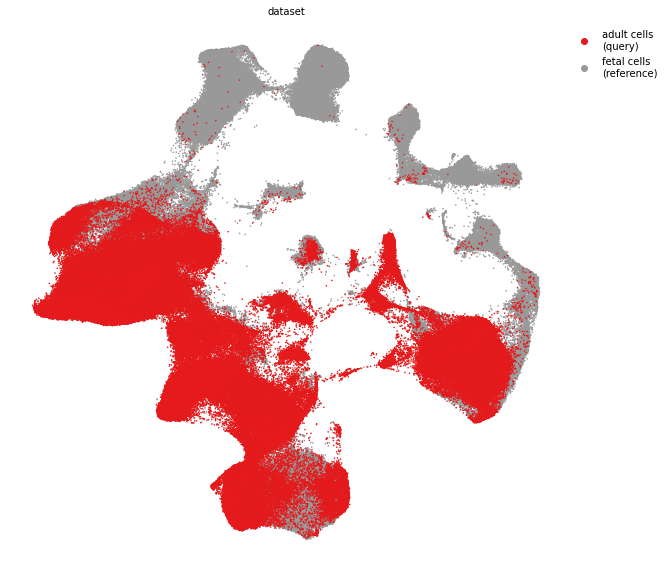

In [143]:
plt.rcParams["figure.figsize"] = [10,10]
merged_adata.obs['dataset_pl'] = ['fetal cells\n(reference)' if x=='reference' else 'adult cells\n(query)' for x in merged_adata.obs['dataset']]
scv.pl.umap(merged_adata, color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
#             save="dataset_q2r.pdf"
           )

Trying to set attribute `.uns` of view, copying.


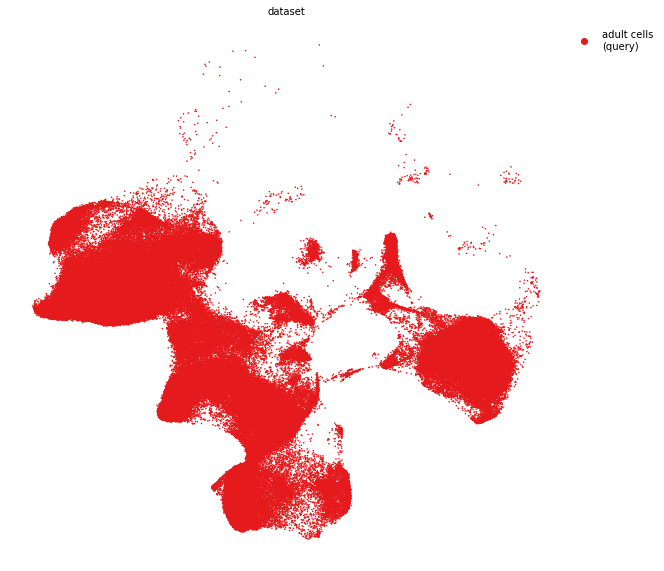

Trying to set attribute `.uns` of view, copying.


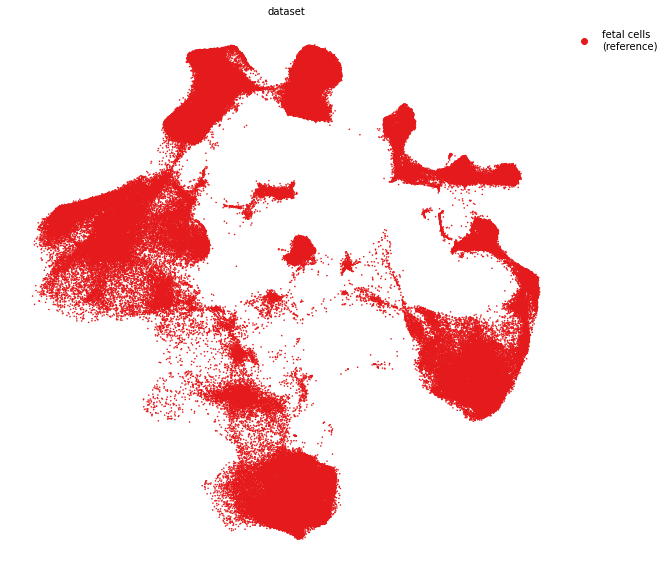

In [144]:
scv.pl.umap(merged_adata[merged_adata.obs['dataset'] == 'query'], color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
#             save="dataset_q2r.pdf"
           )
scv.pl.umap(merged_adata[merged_adata.obs['dataset'] == 'reference'], color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
#             save="dataset_q2r.pdf"
           )

In [145]:
merged_adata.obs["dataset"].value_counts()

query        264929
reference    236119
Name: dataset, dtype: int64

### Plot query and reference annotations

In [309]:
anno_labels_pl = {
#     'Tnaive/CM_CD4_activated':'Tnaive/CM_CD4',
#     'Tem/emra_CD8':'Trm/em_CD8',
#     'Trm_gut_CD8':'Trm/em_CD8',
#     'Tgd_CRTAM+':'Tgd',
#     'Trm_Tgd':'Tgd',
    'GC_B (I)':'GC B',
    'GC_B (II)':'GC B'
}

plt.rcParams['figure.figsize'] = [12,12]
merged_adata.obs["annotation_query_pl"] = [anno_labels_pl[x] if x in anno_labels_pl.keys() else x for x in merged_adata.obs["annotation_query"]]
label_counts = merged_adata.obs["annotation_query_pl"].value_counts()
anno_labels = label_counts.index[label_counts > 10]

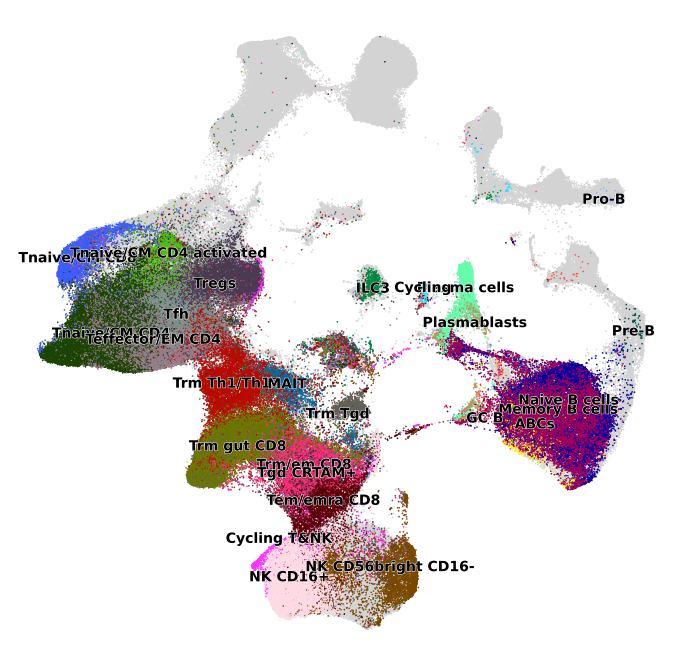

In [310]:
scv.pl.umap(merged_adata, color=["annotation_query_pl"], 
            size=10, 
            palette=sc.pl.palettes.godsnot_102,
            legend_loc="on data", groups=anno_labels, title="", 
            legend_fontsize=14, 
#             save="anno_query.png"
           )

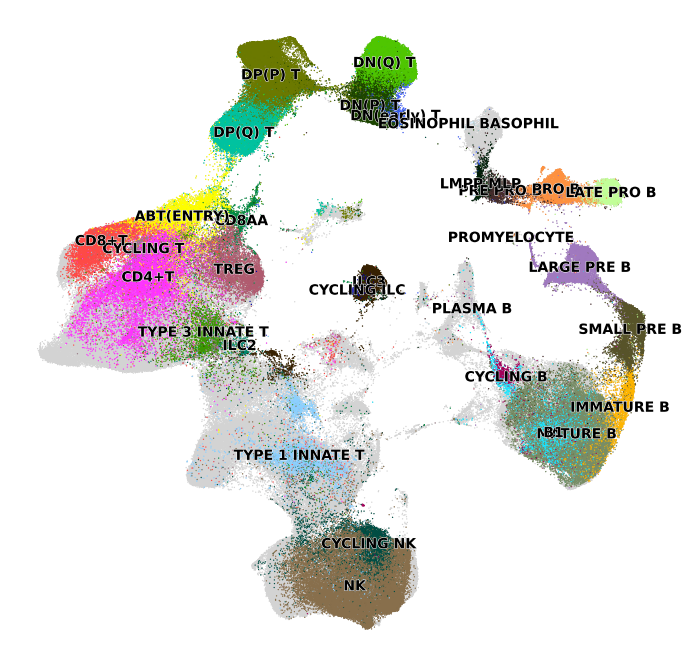

In [288]:
anno_labels = merged_adata.obs["annotation_reference"][merged_adata.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["PROGENITORS"]]
anno_labels = [x for x in anno_labels if sum(merged_adata.obs['annotation_reference'] == x) > 30]

scv.pl.umap(merged_adata, color=["annotation_reference"], size=7, legend_loc="on data", groups=anno_labels, 
            legend_fontsize=14,
            title="",
#            save="anno_reference.png"
           )

In [149]:
def _compute_invivoVSinvitro_distance(merged_adata, 
                                      q_cl, ## query cluster
                                      r_cl, ## reference cluster
                                      q_obs = 'annotation_query',
                                      r_obs = 'annotation_reference',
                                     ):
    keep_invitro_cells = (merged_adata.obs['dataset'] == 'query') & (merged_adata.obs[q_obs] == q_cl)
    keep_invivo_cells = (merged_adata.obs['dataset'] == 'reference') & (merged_adata.obs[r_obs] == r_cl)

    X_dims = merged_adata.obsm['X_scvi'].copy()
    X_dims_invivo = X_dims[keep_invivo_cells,:]
    X_dims_invitro = X_dims[keep_invitro_cells,:]
    dmat = scipy.spatial.distance.cdist( X_dims_invitro, X_dims_invivo, metric='euclidean')
    min_dist = np.min(dmat, 1)
    min_dist = map_query_utils._scArches_adjusted_dist(min_dist)
    min_dist_df = pd.DataFrame(min_dist, columns=['min_dist'])
    min_dist_df['ref_population'] = r_cl
    min_dist_df['query_population'] = q_cl 
    min_dist_df['cell_barcode'] = merged_adata.obs_names[keep_invitro_cells]
    return(min_dist_df)

def _compute_within_distance(merged_adata, 
                                      q_cl, ## query cluster
                                      q_obs = 'annotation_query',
                                     ):
    keep_invitro_cells = (merged_adata.obs['dataset'] == 'query') & (merged_adata.obs[q_obs] == q_cl)
    X_dims = merged_adata.obsm['X_scvi'].copy()
    X_dims_invitro = X_dims[keep_invitro_cells,:]
    mean_dist = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X_dims_invitro, metric='cosine')).min()
    return(mean_dist)

ref_cts = anno_groups_dict['NK/T CELLS']
que_cts = merged_adata.obs["annotation_query"].unique().dropna()

ct_distances_df = pd.DataFrame()
for r in ref_cts:
    for q in que_cts:
        d = _compute_invivoVSinvitro_distance(merged_adata, q_cl=q, r_cl=r)
        ct_distances_df = pd.concat([ct_distances_df, d])

In [251]:
df = ct_distances_df[ct_distances_df['ref_population'].isin(['TREG', 'TYPE_1_INNATE_T', 'TYPE_3_INNATE_T', "CD4+T"])]

mean_dist_df = df.groupby(['ref_population', 'query_population']).mean().reset_index()
mean_dist_df['sd_min_dist'] = df.groupby(['ref_population', 'query_population']).std().reset_index()['min_dist']
mean_dist_df

ref_population query_population  min_dist  sd_min_dist
0              CD4+T             ABCs  0.286734     0.048886
1              CD4+T          Cycling  0.159743     0.020558
2              CD4+T     Cycling T&NK  0.213359     0.063218
3              CD4+T         GC_B (I)  0.253543     0.056741
4              CD4+T        GC_B (II)  0.239516     0.045900
..               ...              ...       ...          ...
103  TYPE_3_INNATE_T            Tregs  0.452613     0.067291
104  TYPE_3_INNATE_T       Trm/em_CD8  0.430001     0.066612
105  TYPE_3_INNATE_T          Trm_Tgd  0.287996     0.051576
106  TYPE_3_INNATE_T     Trm_Th1/Th17  0.515004     0.074101
107  TYPE_3_INNATE_T      Trm_gut_CD8  0.383852     0.057273

[108 rows x 4 columns]

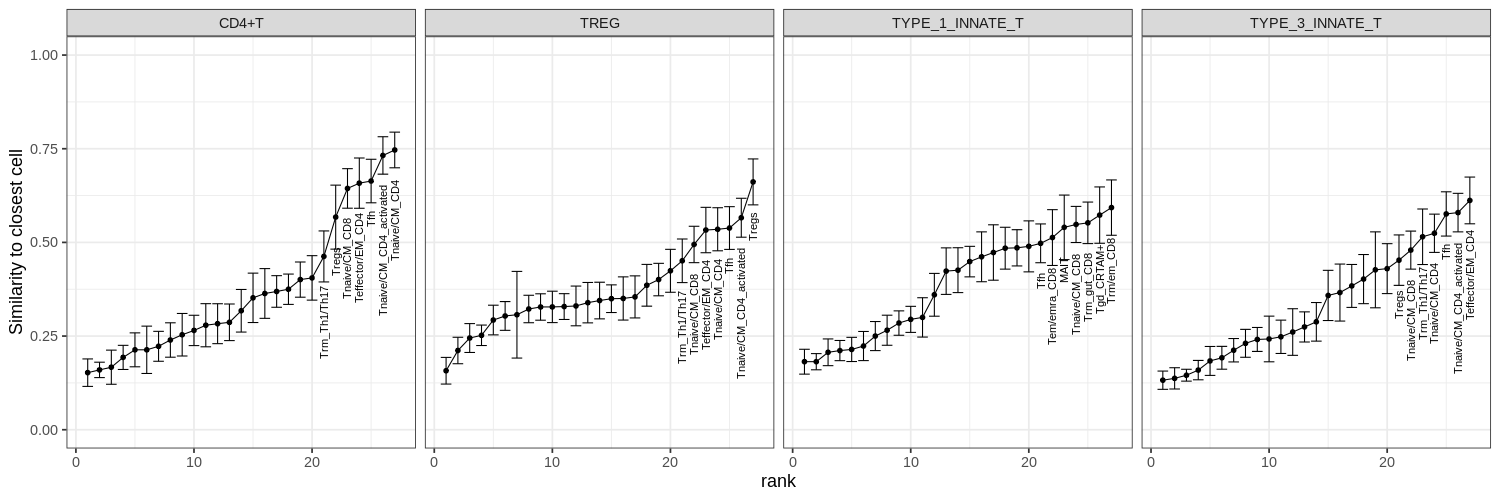

In [252]:
%%R -w 1500 -h 500 -i mean_dist_df
mean_dist_df %>% 
group_by(ref_population) %>%
mutate(rank = rank(min_dist)) %>%
ungroup() %>%
ggplot(aes(rank, min_dist)) +
geom_point(size=2) +
geom_line() +
geom_errorbar(aes(ymin=min_dist-(sd_min_dist), ymax=min_dist+(sd_min_dist))) +
geom_text(data = . %>% filter(rank> 20), aes(label=query_population), nudge_y=-0.08, hjust = 1, angle=90) +
# geom_boxplot() +
# coord_flip() +
facet_wrap(ref_population~., ncol=4) +
ylim(0,1) +
theme_bw(base_size=18) +
ylab("Similarity to closest cell") 

### Transfer labels

In [15]:
# # min_ref_neighbors = adata.uns["neighbors"]["params"]["n_neighbors"]/10
# missing_anno = merged_adata.obs["dataset"] == "query"

# ## Find neighbors of cells with conflicting annotation
# knn_graph = merged_adata.obsp['distances']
# knn_graph_query = knn_graph[missing_anno,:]
# # knn_graph_query[knn_graph_query.nonzero()] = 1

In [219]:
def predict_label2(merged_adata, anno_col = 'annotation_reference', k=50, min_score = 0.5):
    '''
    Predict annotation labels for query cells based on k-NNs in the reference data
    '''
    import time
    from scipy.spatial import cKDTree

    ## Extract embedding
    X_emb = merged_adata.obsm["X_scvi"].copy()

    is_query = merged_adata.obs["dataset"] == "query"
    is_reference = merged_adata.obs["dataset"] == "reference"

    X_emb_ref = X_emb[is_reference,:]
    X_emb_que = X_emb[is_query,:]

    ## Find nearest neighbors in reference
    k1=k2=k
    data_query = X_emb_que
    data_ref = X_emb_ref
    start = time.time()
    k_index_ref = cKDTree(data_ref).query(x=data_query, k=k1, n_jobs=5)[1]
    end = time.time()
    print(end - start)

    knn_mat = np.zeros(shape=[sum(is_query),sum(is_reference)])
    for i in range(k_index_ref.shape[0]):
        knn_mat[i, k_index_ref[i]] = 1

    ## Subset to reference cells that have are NN to at least one query cell
    keep_ref_ixs = np.unique(k_index_ref.ravel())
    keep_ref_ixs.sort()
    small_knn_mat = knn_mat[:,keep_ref_ixs]

    ## Make dummy matrix of annotations
    annos = merged_adata[is_reference].obs[anno_col][keep_ref_ixs].copy()
    dummy_df = pd.get_dummies(annos)
    dummy_mat = dummy_df.values

    ## Sum number of neighbors with each annotation
    new_anno = small_knn_mat.dot(dummy_mat)

    ## Find top scorers
    n_neighbors = np.array(small_knn_mat.sum(1)).flatten()
    n_neighbors_ref = new_anno.sum(axis=1)
    new_anno_prob = new_anno.T/n_neighbors_ref
    new_anno_prob[np.isnan(new_anno_prob)] = 0
    best_label = dummy_df.columns[new_anno_prob.argmax(0)].values
    best_label_score = new_anno_prob.max(0)
    best_label = best_label.astype('str')

    ## Call low confidence if probability is < min_score
    best_label_all = best_label.copy()
    best_label[best_label_score <= min_score] = "low_confidence"

    ## Save output in place
    del merged_adata.obs['predicted_anno'] 
    merged_adata.obs['predicted_anno'] = np.nan
    merged_adata.obs['predicted_anno_unfiltered'] = np.nan
    merged_adata.obs['predicted_anno_prob'] = np.nan
    merged_adata.obs.loc[is_query,'predicted_anno'] = best_label
    merged_adata.obs.loc[is_query,'predicted_anno_unfiltered'] = best_label_all
    merged_adata.obs.loc[is_query,'predicted_anno_prob'] = best_label_score

---

In [220]:
smp_merged_adata = sc.pp.subsample(merged_adata, fraction=0.25, copy=True)

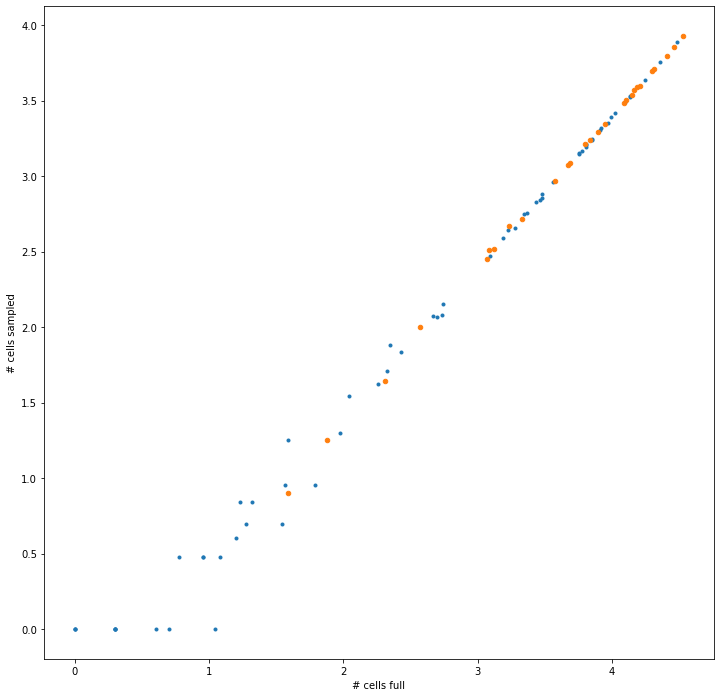

In [221]:
## Check cell numbers 
df = pd.concat([smp_merged_adata.obs.groupby('annotation_reference').size(), merged_adata.obs.groupby('annotation_reference').size()], 1)
plt.plot(np.log10(df[1]), np.log10(df[0]), '.', label='reference anno');
df = pd.concat([smp_merged_adata.obs.groupby('annotation_query').size(), merged_adata.obs.groupby('annotation_query').size()], 1)
sns.set_context('talk')
plt.plot(np.log10(df[1]), np.log10(df[0]), '.', label='query anno');
plt.xlabel('# cells full');plt.ylabel('# cells sampled');

In [222]:
smp_merged_adata.obs["annotation_reference"] = smp_merged_adata.obs["annotation_reference"].astype("str").replace("nan", np.nan)
if 'predicted_anno' in smp_merged_adata.obs.columns:
    smp_merged_adata.obs.drop('predicted_anno', 1, inplace=True)
map_query_utils.predict_label2(smp_merged_adata, anno_col="annotation_reference")

25.28495192527771


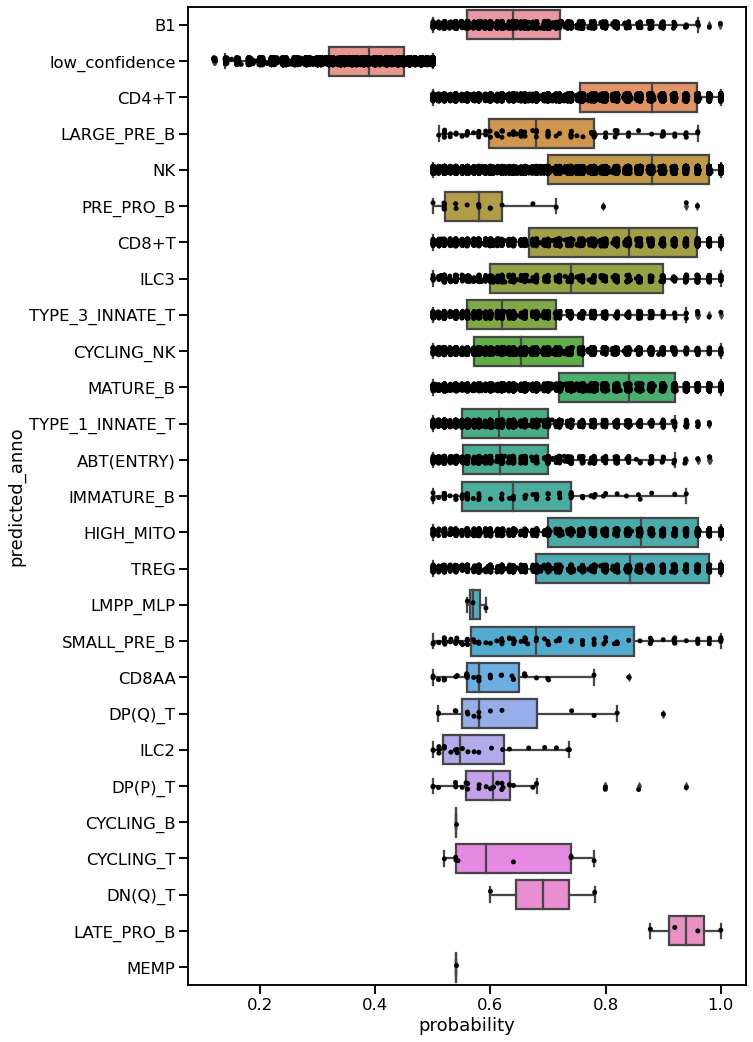

In [223]:
plt.rcParams["figure.figsize"] = [10,18]
map_query_utils.plot_predicted_anno_probability(smp_merged_adata)

In [224]:
sns.set_context("talk")
query_anno_col="annotation_query"

query_obs = smp_merged_adata.obs_names[smp_merged_adata.obs.dataset == "query"]
empty_query = query_obs[smp_merged_adata[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = smp_merged_adata[~smp_merged_adata.obs_names.isin(empty_query)].copy()
merged_adata_clean.obs[query_anno_col] = merged_adata_clean.obs[query_anno_col].astype("str")

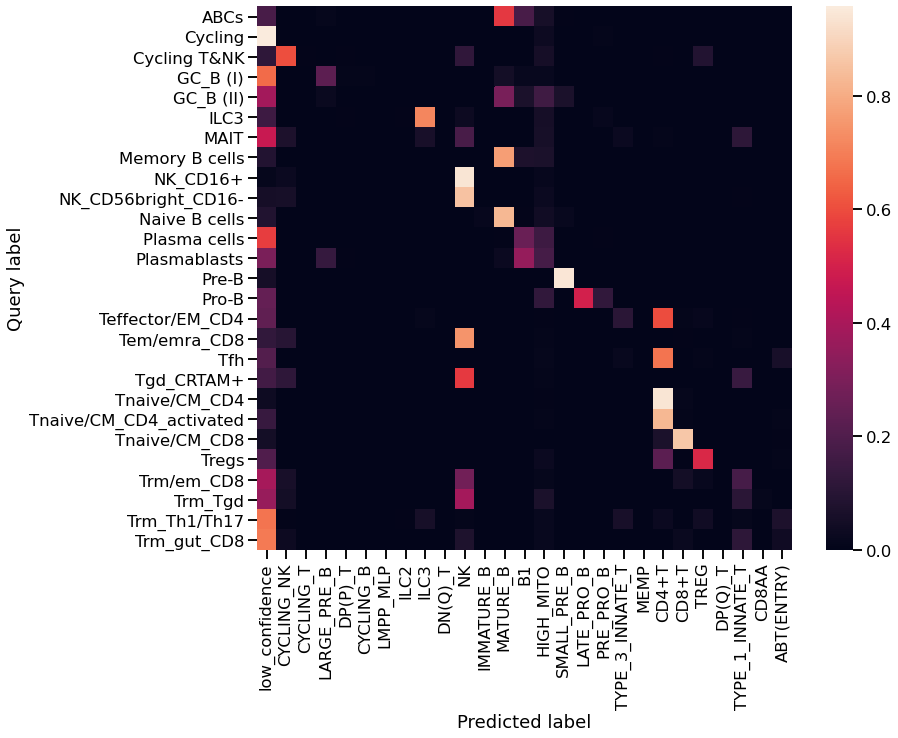

In [225]:
plt.rcParams["figure.figsize"] = [12,10]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)

### Quantify matching between datasets

In [226]:
import time
## Calculate distance of a query cell to closest cell of 
# predicted annotation

def _compute_min_dist2predicted_anno(merged_adata, r_cl,
#                                      q_cell,
                                     r_obs = 'annotation_reference',
                                     pred_anno_obs = 'predicted_anno_unfiltered'
                                    ):
    from scipy.spatial import cKDTree
    # Pick reference cluster 
    keep_ref_cells = (merged_adata.obs['dataset'] == 'reference') & (merged_adata.obs[r_obs] == r_cl)
    keep_query_cells = (merged_adata.obs['dataset'] == 'query') & (merged_adata.obs[pred_anno_obs] == r_cl)

    ## Calculate distance of query cell to all reference
    # cells in cluster
    X_dims = merged_adata.obsm['X_scvi'].copy()
    X_dims_invivo = X_dims[keep_ref_cells,:]
    X_dims_invitro = X_dims[keep_query_cells,:]
    k_ref = cKDTree(X_dims_invivo).query(x=X_dims_invitro, k=1, n_jobs=5)
    min_dists = k_ref[0]
    min_dists_df = pd.DataFrame(zip(merged_adata.obs_names[keep_query_cells],min_dists), columns=['query_cell', 'min_distance2pred'])
    return(min_dists_df)

start = time.time()
smp_merged_adata.obs['min_distance2pred'] = np.nan
counter = 0
is_query = smp_merged_adata.obs["dataset"] == "query"
is_reference = smp_merged_adata.obs["dataset"] == "reference"
for r_cl in smp_merged_adata.obs['predicted_anno_unfiltered'].unique():
    counter += 1
    min_dists_df = _compute_min_dist2predicted_anno(smp_merged_adata, r_cl)
    smp_merged_adata.obs.loc[min_dists_df.query_cell, 'min_distance2pred'] = min_dists_df.min_distance2pred.values
    print(counter)
## Normalize w gaussian kernel
smp_merged_adata.obs.loc[is_query, 'min_distance2pred'] = map_query_utils._scArches_adjusted_dist(smp_merged_adata.obs.loc[is_query, 'min_distance2pred'].astype('float').values)
end = time.time()
print(end-start)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
2.0980916023254395


### Combined similarity & confusion matrix

In [254]:
q_df = smp_merged_adata[smp_merged_adata.obs['dataset'] == 'query'].obs[["min_distance2pred", "predicted_anno", "annotation_query", 'organ_code']]
q_df = q_df[~q_df.annotation_query.isna()]
q_df.annotation_query = q_df.annotation_query.astype('str')
q_df.min_distance2pred = q_df.min_distance2pred.astype('float')

In [261]:
query_anno_group_lymphoid = {
    "B cells":[x for x in q_df.annotation_query.unique() if x.endswith("B cells") or x.endswith("B") or "GC_B" in x or x=="B_prog" or "Plasma" in x or x=='ABCs'],
    "NK cells":[x for x in q_df.annotation_query.unique() if x.startswith("NK")],
    "other":[x for x in q_df.annotation_query.unique() if 'doublets' in x],
    }

query_anno_group_lymphoid['T cells'] = [x for x in q_df.annotation_query.unique() if x not in sum(query_anno_group_lymphoid.values(),[])]
query_anno_group_lymphoid_rev = {x:g for g,a in query_anno_group_lymphoid.items() for x in a}

ref_anno_group_lymphoid = {
    "NK cells":[x for x in q_df.predicted_anno.unique() if x.endswith("NK")],
    "ILCs":[x for x in q_df.predicted_anno.unique() if x.startswith("ILC")],
    "B cells":[x for x in q_df.predicted_anno.unique() if x.endswith("B") or x=="B1"],
    "T cells":[x for x in q_df.predicted_anno.unique() if x.endswith("T") or x=="ABT(ENTRY)" or x=="CD8AA" or x=="TREG"],
    'low_confidence':['low_confidence']
    }

ref_anno_group_lymphoid['other'] = [x for x in q_df.predicted_anno.unique() if x not in sum(ref_anno_group_lymphoid.values(),[])]
ref_anno_group_lymphoid_rev = {x:g for g,a in ref_anno_group_lymphoid.items() for x in a}

q_df['annotation_query_group'] = [query_anno_group_lymphoid_rev[x] for x in q_df['annotation_query']]
q_df['predicted_anno_group'] = [ref_anno_group_lymphoid_rev[x] for x in q_df['predicted_anno']]

`summarise()` has grouped output by 'predicted_anno', 'annotation_query', 'annotation_query_group', 'predicted_anno_group'. You can override using the `.groups` argument.


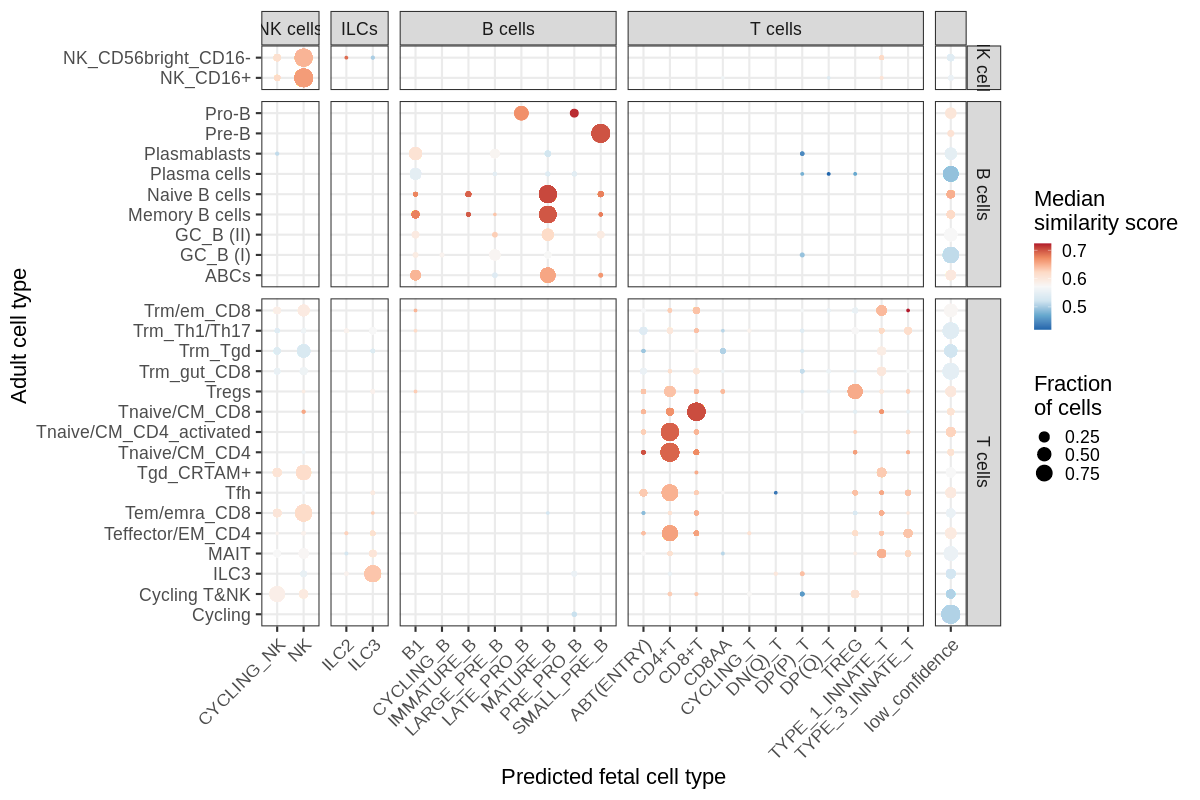

In [262]:
%%R -i q_df -h 800 -w 1200 
q_df %>%
    group_by(annotation_query) %>%
    mutate(tot_cells=n()) %>%
    ungroup() %>%
    group_by(predicted_anno, annotation_query, annotation_query_group, predicted_anno_group) %>%
    summarise(frac_cells=n()/tot_cells, median_sim_score=median(min_distance2pred)) %>%
    ungroup() %>%
    filter(annotation_query_group != 'other' & predicted_anno_group != 'other' ) %>%
    mutate(annotation_query_group=factor(annotation_query_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells'))) %>%
    mutate(predicted_anno_group = ifelse(predicted_anno_group=="low_confidence", '', predicted_anno_group)) %>%
    mutate(predicted_anno_group=factor(predicted_anno_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells', ''))) %>%
    ggplot(aes(predicted_anno, annotation_query)) +
    scale_size(range=c(1,8), name="Fraction\nof cells") +
#     geom_point(aes(size=frac_cells, fill=median_sim_score), shape=21) +
#     scale_fill_distiller(palette="RdBu", direction=-1, name='Median\nsimilarity score') +
    geom_point(aes(size=frac_cells, color=median_sim_score)) +
    scale_color_distiller(palette="RdBu", direction=-1, name='Median\nsimilarity score') +
    facet_grid(annotation_query_group~as.factor(predicted_anno_group), space="free", scales='free') +
    xlab("Predicted fetal cell type") + ylab("Adult cell type") +
    theme_bw(base_size=22) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) 
#     ggsave(paste0(figdir, "adult_confusion_similarity_dotplot.pdf"), width=15, height=10)

In [446]:
q_df

min_distance2pred  predicted_anno  \
CZINY-0100_GTGTGGCCAGACACAG-query             0.548714              B1   
CZINY-0054_ACCCAAATCAAACGAA-query             0.584404  low_confidence   
CZINY-0101_TATCAGGCAAGCGCTC-query             0.660238           CD4+T   
CZINY-0050_AGTACTGCACTGGCGT-query             0.630936     LARGE_PRE_B   
CZINY-0057_ACACCAATCGTCACCT-query             0.610066              NK   
...                                                ...             ...   
CZINY-0109_ATCGTAGCATGTGGCC-query             0.595925              NK   
CZINY-0058_GGGAAGTTCAATCTCT-query             0.689829           CD4+T   
CZINY-0104_CACGTGGGTGTCGATT-query             0.711506           CD4+T   
CZINY-0106_AATCGACAGGAAGTAG-query             0.747328              NK   
Pan_T7991591_AGGTCATGTTTGACAC-query           0.574850  low_confidence   

                                    annotation_query organ_code  \
CZINY-0100_GTGTGGCCAGACACAG-query       Plasma cells        LLN   
CZINY-0054_ACCCAAATCAAACGAA-query        Trm_gut_CD8     JEJEPI   
CZINY-0101_TATCAGGCAAGCGCTC-query      Tnaive/CM_CD4        SPL   
CZINY-0050_AGTACTGCACTGGCGT-query       Plasmablasts        SPL   
CZINY-0057_ACACCAATCGTCACCT-query           NK_CD16+        BLD   
...                                              ...        ...   
CZINY-0109_ATCGTAGCATGTGGCC-query       Tem/emra_CD8        BMA   
CZINY-0058_GGGAAGTTCAATCTCT-query      Tnaive/CM_CD4        SPL   
CZINY-0104_CACGTGGGTGTCGATT-query      Tnaive/CM_CD4        LNG   
CZINY-0106_AATCGACAGGAAGTAG-query           NK_CD16+        BMA   
Pan_T7991591_AGGTCATGTTTGACAC-query   Memory B cells        SPL   

                                    annotation_query_group  \
CZINY-0100_GTGTGGCCAGACACAG-query                  B cells   
CZINY-0054_ACCCAAATCAAACGAA-query                  T cells   
CZINY-0101_TATCAGGCAAGCGCTC-query                  T cells   
CZINY-0050_AGTACTGCACTGGCGT-query                  B cells   
CZINY-0057_ACACCAATCGTCACCT-query                 NK cells   
...                                                    ...   
CZINY-0109_ATCGTAGCATGTGGCC-query                  T cells   
CZINY-0058_GGGAAGTTCAATCTCT-query                  T cells   
CZINY-0104_CACGTGGGTGTCGATT-query                  T cells   
CZINY-0106_AATCGACAGGAAGTAG-query                 NK cells   
Pan_T7991591_AGGTCATGTTTGACAC-query                B cells   

                                    predicted_anno_group  
CZINY-0100_GTGTGGCCAGACACAG-query                B cells  
CZINY-0054_ACCCAAATCAAACGAA-query         low_confidence  
CZINY-0101_TATCAGGCAAGCGCTC-query                T cells  
CZINY-0050_AGTACTGCACTGGCGT-query                B cells  
CZINY-0057_ACACCAATCGTCACCT-query               NK cells  
...                                                  ...  
CZINY-0109_ATCGTAGCATGTGGCC-query               NK cells  
CZINY-0058_GGGAAGTTCAATCTCT-query                T cells  
CZINY-0104_CACGTGGGTGTCGATT-query                T cells  
CZINY-0106_AATCGACAGGAAGTAG-query               NK cells  
Pan_T7991591_AGGTCATGTTTGACAC-query       low_confidence  

[66215 rows x 6 columns]

In [445]:
merged_adata.obs['age']

FCAImmP7579224-CTAATGGCACTGTGTA-reference    12.0
FCAImmP7579224-GACGGCTAGCCACCTG-reference    12.0
FCAImmP7579224-GCGGGTTGTCCGAGTC-reference    12.0
FCAImmP7579224-AGTTGGTAGTGTTAGA-reference    12.0
FCAImmP7579224-TCTTTCCCAAGCCGTC-reference    12.0
                                             ... 
CZINY-0112_TTTGGTTAGGCCACTC-query             NaN
CZINY-0112_TTTGGTTCACAAAGTA-query             NaN
CZINY-0112_TTTGGTTTCCATCACC-query             NaN
CZINY-0112_TTTGTTGCAGCGGTTC-query             NaN
CZINY-0112_TTTGTTGGTGCGACAA-query             NaN
Name: age, Length: 501048, dtype: float64

In [80]:
## Save for future plotting
q_df.to_csv('/nfs/team205/ed6/data/Fetal_immune/panimmune_full_LYMPHOID_query.mapped2LYMPHOID_NEW.confusion_table.csv')

### Save outputs

In [12]:
# merged_adata.obs['min_distance2pred'] = merged_adata.obs['min_distance2pred'].astype('float')
# merged_adata.write_h5ad(data_dir + merged_adata_file)
# merged_adata = sc.read_h5ad(data_dir + merged_adata_file)

In [112]:
data_dir

'/nfs/team205/ed6/data/Fetal_immune/'

In [121]:
pi_adata = sc.read_h5ad('/nfs/team205/cx1/Celltypist/revision_science/data/PIP_global_object_raw_count.h5ad', backed='r')
adata_fetal = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.20210429.h5ad', backed='r')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Similarity by age

In [477]:
cut_labels_4 = ['< 8pcw', '< 10pcw', '< 12pcw', '< 14pcw', '< 16pcw', '< 18pcw']
cut_bins = [0, 8, 10, 12, 14, 16, 18]

smp_merged_adata.obs["age_bins"] = pd.cut(smp_merged_adata.obs["age"], bins=cut_bins, labels=cut_labels_4).astype("str")
smp_merged_adata.obs["age_bins"] = pd.Categorical(smp_merged_adata.obs["age_bins"], categories=cut_labels_4, ordered=True)
smp_merged_adata.obs['age_bins'] = smp_merged_adata.obs['age_bins'].cat.codes

In [500]:
np.arange(6)

array([0, 1, 2, 3, 4, 5])

(125262,)

In [676]:
r_obs = 'annotation_reference'
age_min_dist_df = pd.DataFrame()
X_dims = smp_merged_adata.obsm['X_scvi'].copy()

for r_cl in smp_merged_adata.obs['predicted_anno'].dropna().unique():
#     for r_age in np.arange(6):
    keep_query_cells = (smp_merged_adata.obs['dataset'] == 'query') & (smp_merged_adata.obs['predicted_anno'] == r_cl)
    keep_ref_cells = (smp_merged_adata.obs['dataset'] == 'reference') & (smp_merged_adata.obs['annotation_reference'] == r_cl)
    if sum(keep_ref_cells) > 0:
        X_dims_ref = X_dims[keep_ref_cells,:]
        X_dims_query = X_dims[keep_query_cells,:]
        dmat = scipy.spatial.distance.cdist( X_dims_query, X_dims_ref, metric='euclidean')
        min_dist = np.min(dmat, 1)
        min_dist_ix = np.argmin(dmat, 1)
        min_dist = map_query_utils._scArches_adjusted_dist(min_dist)
        min_dist_df = pd.DataFrame(min_dist, columns=['min_dist'])
        min_dist_df['ref_population'] = r_cl
#         min_dist_df['ref_age_bin'] = r_age
        min_dist_df['closest_ref_age'] = smp_merged_adata.obs_names[keep_ref_cells][min_dist_ix].values
        min_dist_df['cell_barcode'] = smp_merged_adata.obs_names[keep_query_cells]
        age_min_dist_df = pd.concat([age_min_dist_df, min_dist_df])

In [677]:
age_min_dist_df['que_population'] = smp_merged_adata.obs.loc[age_min_dist_df['cell_barcode']]['annotation_query'].values

In [682]:
age_min_dist_df['closest_ref_age'] = smp_merged_adata.obs.loc[age_min_dist_df['closest_ref_age']]['age'].values

In [684]:
mean_age_min_dist_df

que_population   ref_population  ref_age_bin  min_dist  sd_min_dist     n
6              ABCs               B1            0  0.187140     0.055611  59.0
7              ABCs               B1            1  0.369430     0.071753  59.0
8              ABCs               B1            2  0.538012     0.058671  59.0
9              ABCs               B1            3  0.602423     0.059284  59.0
10             ABCs               B1            4  0.537871     0.064207  59.0
...             ...              ...          ...       ...          ...   ...
4207    Trm_gut_CD8  TYPE_3_INNATE_T            1  0.298605     0.078698   2.0
4208    Trm_gut_CD8  TYPE_3_INNATE_T            2  0.501816     0.126241   2.0
4209    Trm_gut_CD8  TYPE_3_INNATE_T            3  0.542178     0.046845   2.0
4210    Trm_gut_CD8  TYPE_3_INNATE_T            4  0.507313     0.064229   2.0
4211    Trm_gut_CD8  TYPE_3_INNATE_T            5  0.443990     0.124781   2.0

[972 rows x 6 columns]

In [685]:
mean_age_min_dist_df = age_min_dist_df.groupby(['que_population','ref_population']).mean().reset_index()
mean_age_min_dist_df['sd_min_dist'] = age_min_dist_df.groupby(['que_population','ref_population']).std().reset_index()['min_dist']
mean_age_min_dist_df['n'] = age_min_dist_df.groupby(['que_population','ref_population']).count().reset_index()['min_dist']
mean_age_min_dist_df = mean_age_min_dist_df.dropna()
mean_age_min_dist_df

que_population   ref_population  min_dist  closest_ref_age  sd_min_dist  \
1             ABCs               B1  0.639851        14.864407     0.053319   
11            ABCs        HIGH_MITO  0.634228        14.894737     0.067066   
15            ABCs      LARGE_PRE_B  0.505837        13.250000     0.011690   
18            ABCs         MATURE_B  0.687292        14.950276     0.052210   
22            ABCs      SMALL_PRE_B  0.686338        14.500000     0.056971   
..             ...              ...       ...              ...          ...   
686    Trm_gut_CD8          DP(Q)_T  0.473825        12.571429     0.076877   
687    Trm_gut_CD8        HIGH_MITO  0.563628        15.268908     0.057990   
696    Trm_gut_CD8               NK  0.558570        12.097713     0.041538   
700    Trm_gut_CD8  TYPE_1_INNATE_T  0.596966        14.253857     0.040754   
701    Trm_gut_CD8  TYPE_3_INNATE_T  0.570248        13.000000     0.063957   

         n  
1     59.0  
11    19.0  
15     4.0  
18   181.0  
22     2.0  
..     ...  
686    7.0  
687  119.0  
696  481.0  
700  713.0  
701    2.0  

[169 rows x 6 columns]

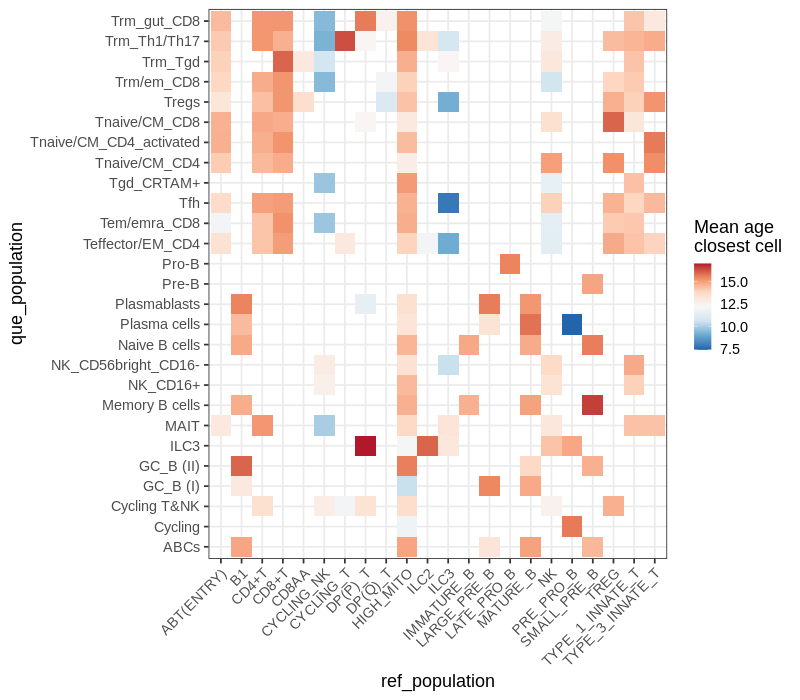

In [691]:
%%R -i mean_age_min_dist_df -i cut_labels_4  -w 800 -h 700
age_bin_names <- setNames(as.character(cut_labels_4), seq(0,5))

mean_age_min_dist_df %>%
    ggplot(aes(ref_population, fill=closest_ref_age, y=que_population)) +
    geom_tile() +
#     geom_line()
#     geom_tile() +
    scale_fill_distiller(palette="RdBu", direction=-1, name='Mean age\nclosest cell') +
#     facet_grid(.~ref_population) +
#     xlab("Fetal age bin") + ylab("Adult population") +
    theme_bw(base_size=18) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

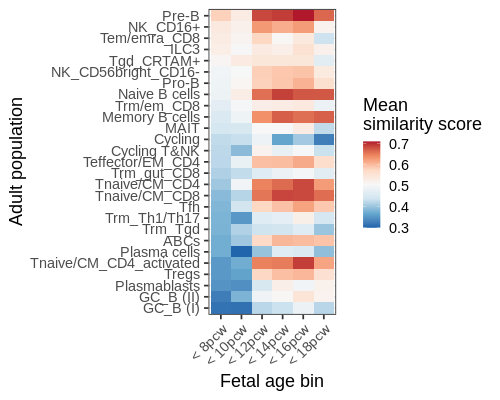

In [625]:
%%R -i mean_age_min_dist_df -i cut_labels_4  -w 500 -h 400
age_bin_names <- setNames(as.character(cut_labels_4), seq(0,5))

mean_age_min_dist_df %>%
    group_by(que_population) %>%
    arrange(ref_age_bin) %>%
    mutate(peak_age = cumsum(min_dist)) %>%
    ungroup() %>%
    arrange(peak_age) %>%
    mutate(que_population= factor(que_population, levels=unique(que_population))) %>%
    mutate(ref_age_bin = factor(age_bin_names[as.character(ref_age_bin)], levels=age_bin_names)) %>%
    ggplot(aes(ref_age_bin, fill=min_dist, y=que_population)) +
#     geom_point() +
#     geom_line()
    geom_tile() +
    scale_fill_distiller(palette="RdBu", direction=-1, name='Mean\nsimilarity score') +
    xlab("Fetal age bin") + ylab("Adult population") +
    theme_bw(base_size=18) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

## Compare with _de novo_ integration

In [263]:
X_scVI_denovo = np.load('/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/merged_fetal_adult.LYMPHOID_NEW.scVI_out.npy')

In [264]:
merged_adata_denovo = sc.read_h5ad('/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/merged_fetal_adult.LYMPHOID_NEW.h5ad')

In [265]:
merged_adata_denovo.obsm['X_scvi'] = X_scVI_denovo.copy()

In [266]:
k_neighbors = 30
sc.pp.neighbors(merged_adata_denovo, n_neighbors=k_neighbors, use_rep="X_scvi")
print("Running UMAP...\n")
sc.tl.umap(merged_adata_denovo, min_dist = 0.01, spread = 2)

Running UMAP...



In [270]:
reference_obs = merged_adata_denovo.obs_names[merged_adata_denovo.obs.dataset == "fetal"]
merged_adata_denovo.obs["annotation_reference"] = np.nan
merged_adata_denovo.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-fetal")]["anno_lvl_2_final_clean"].values

merged_adata_denovo.obs["organ"] = np.nan
merged_adata_denovo.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-fetal")]["organ"].values

merged_adata_denovo.obs["age"] = np.nan
merged_adata_denovo.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-fetal")]["age"].values

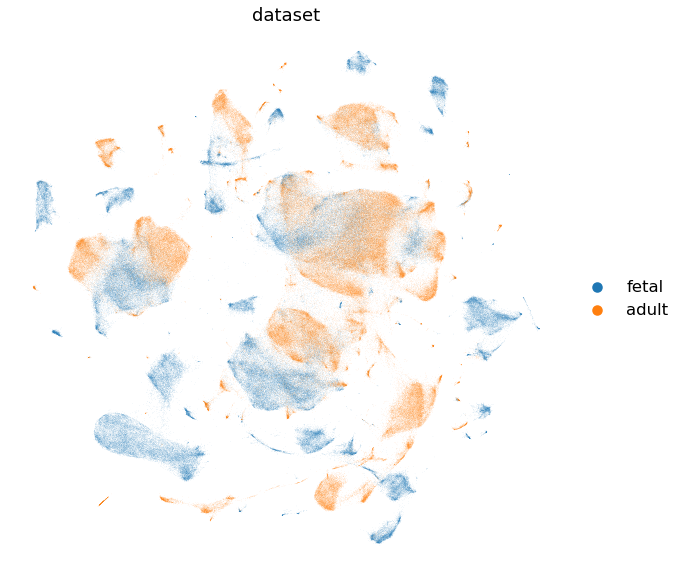

In [308]:
plt.rcParams['figure.figsize'] = [10,10]
scv.pl.umap(merged_adata_denovo, color=['dataset'], legend_loc='right margin')

In [21]:
merged_adata_denovo.var_names =  merged_adata_denovo.var['GeneName'].values

In [276]:
anno_labels = merged_adata_denovo.obs["annotation_reference"][merged_adata_denovo.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["PROGENITORS"]]

In [282]:
anno_labels = [x for x in anno_labels if sum(merged_adata_denovo.obs['annotation_reference'] == x) > 30]

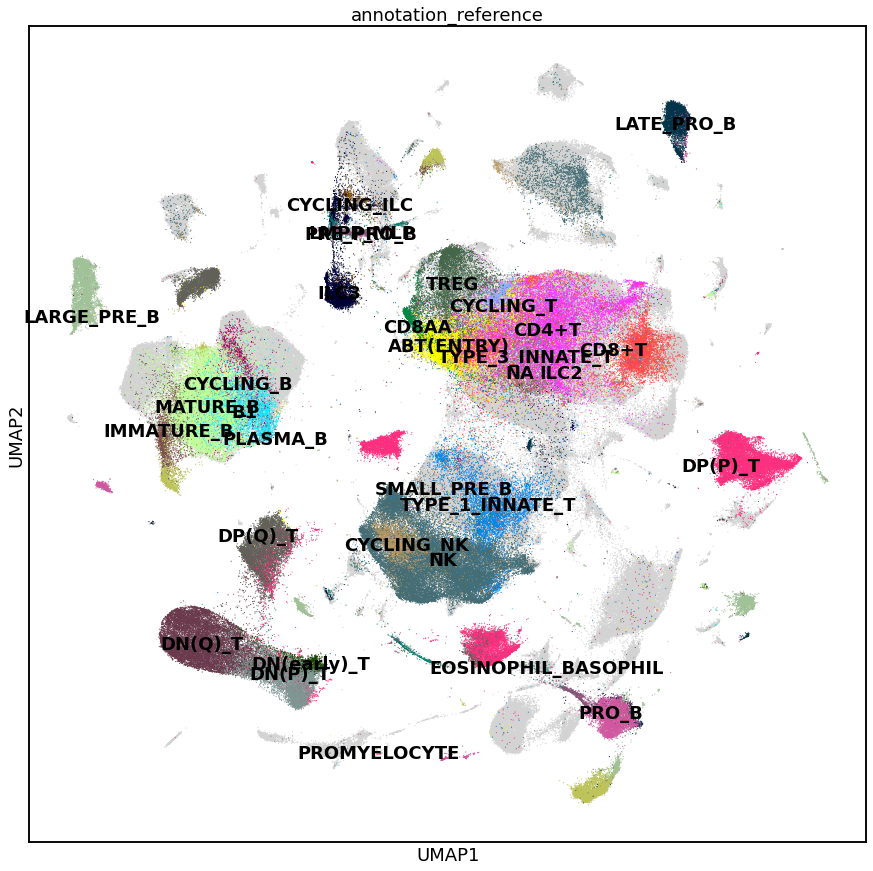

In [283]:
plt.rcParams['figure.figsize'] = [15,15]
sc.pl.umap(merged_adata_denovo, color=['annotation_reference'], legend_loc='on data', size=5, vmax=10, groups=anno_labels)

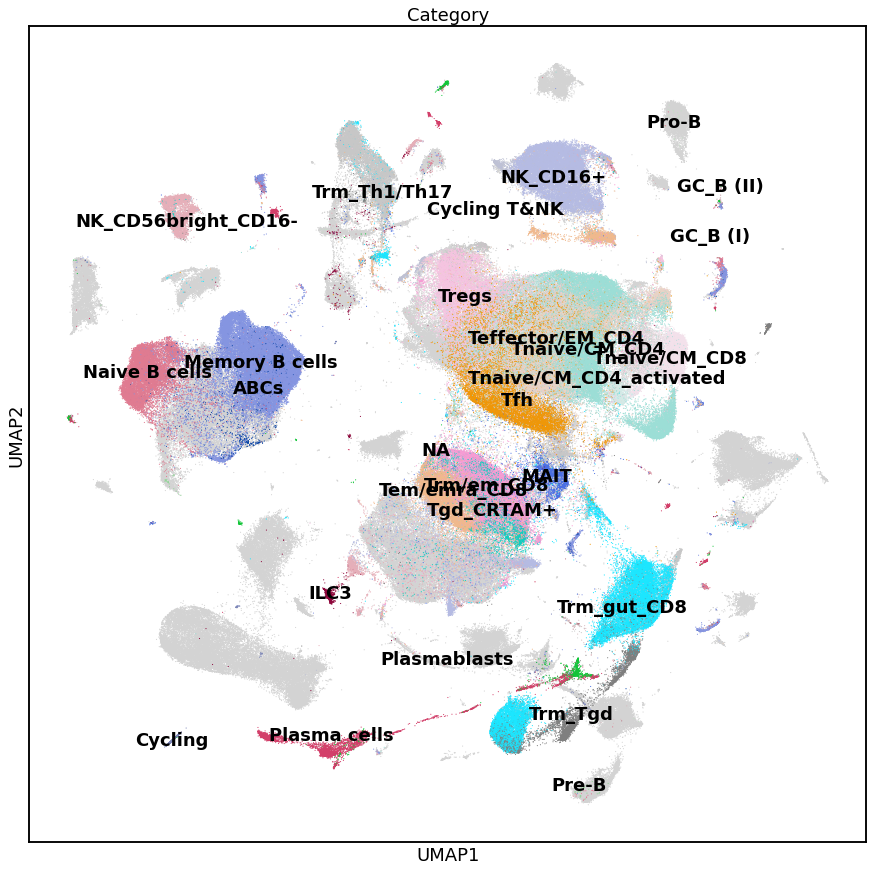

In [275]:
sc.pl.umap(merged_adata_denovo, color=['Category'], legend_loc='on data', size=5, vmax=10)

In [314]:
merged_adata.obs['log_MKI67'] = np.log1p(merged_adata[:,'ENSG00000148773'].X.toarray())
merged_adata_denovo.obs['log_MKI67'] = np.log1p(merged_adata_denovo[:,'ENSG00000148773'].X.toarray())

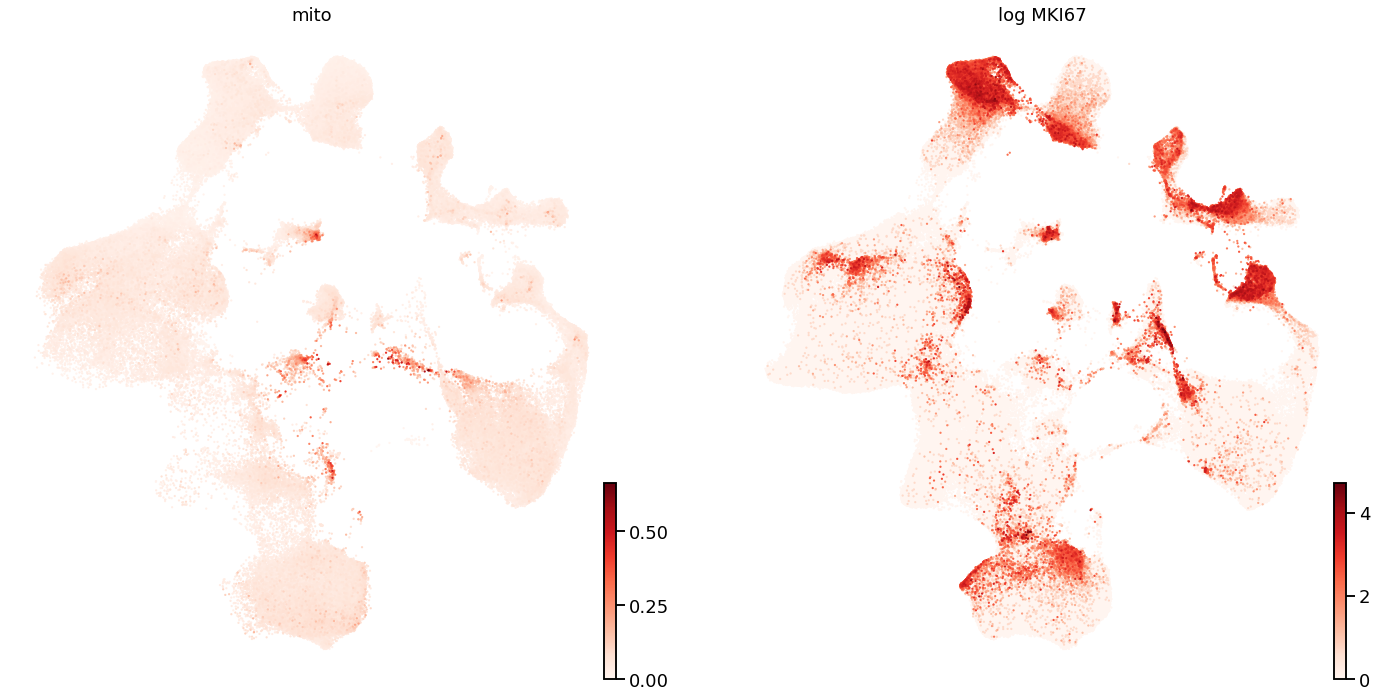

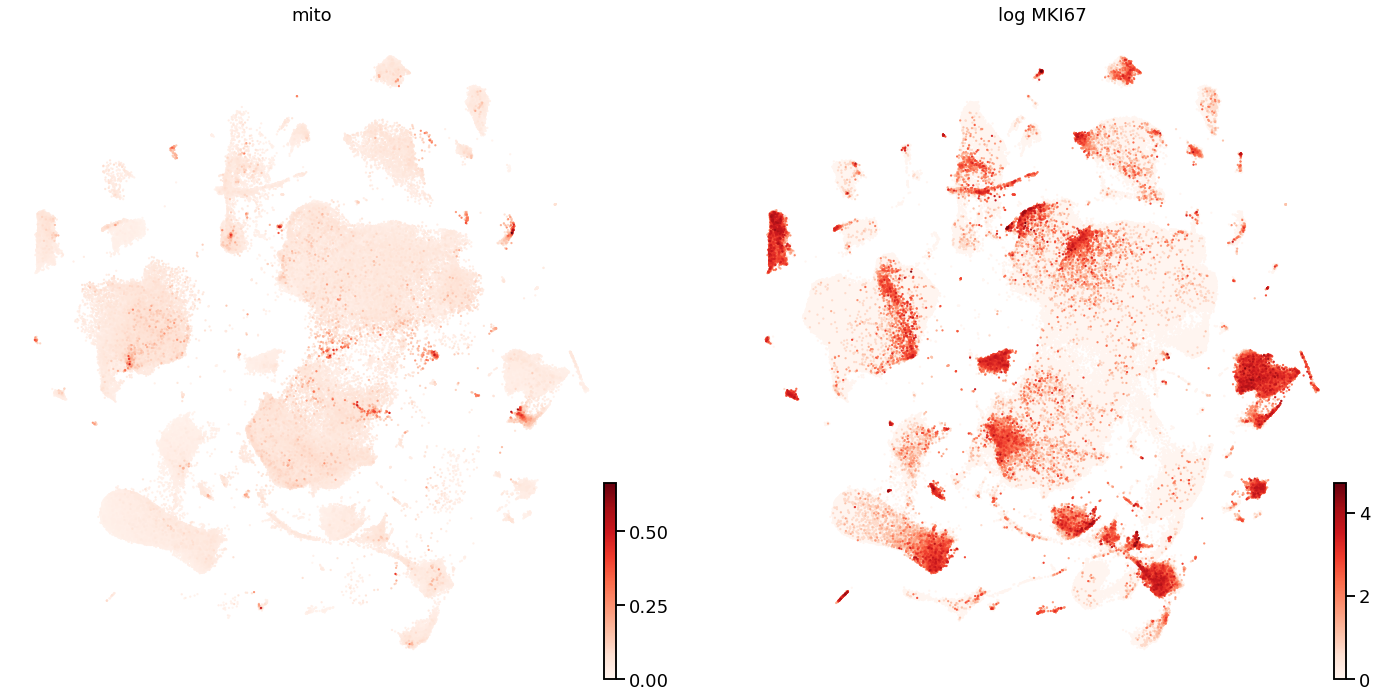

In [315]:
scv.pl.umap(merged_adata, color=["mito", 'log_MKI67'], size=20, legend_loc="on data", cmap='Reds')
scv.pl.umap(merged_adata_denovo, color=["mito", 'log_MKI67'], size=20, legend_loc="on data", cmap='Reds')

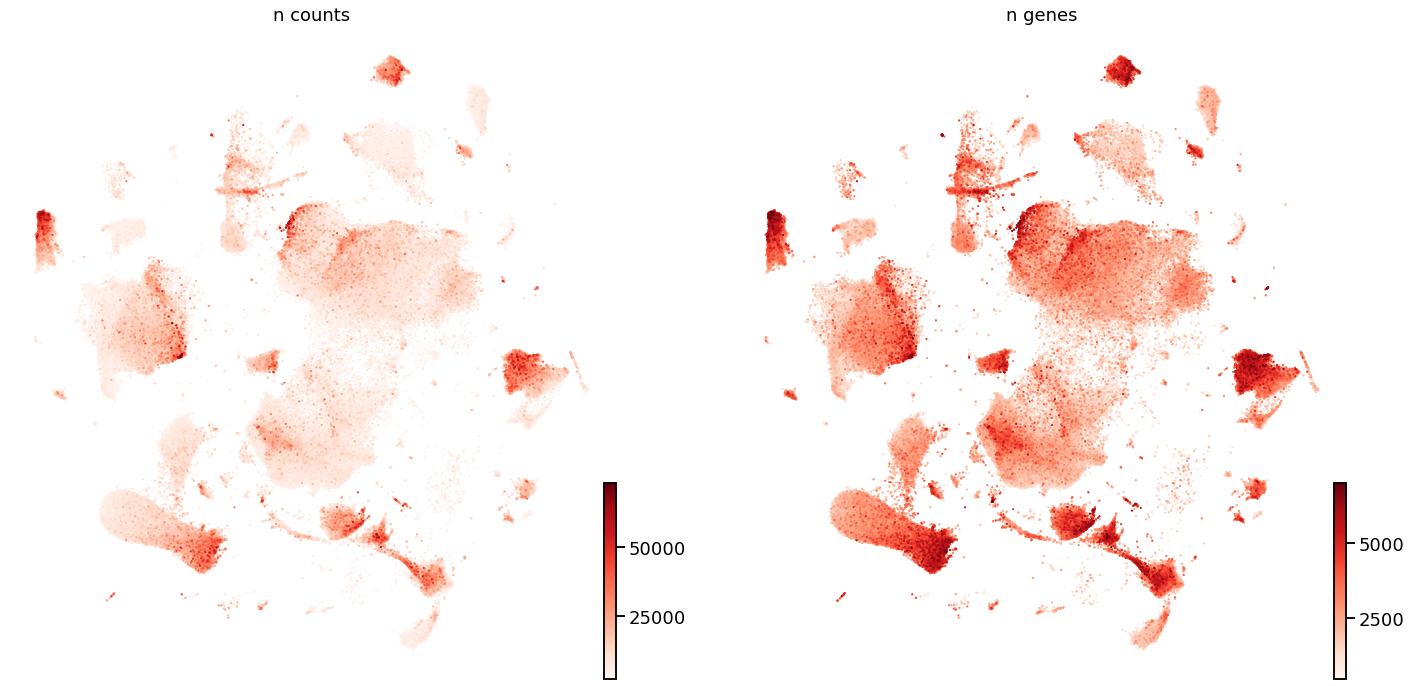

In [316]:
scv.pl.umap(merged_adata_denovo, color=["n_counts", 'n_genes'], size=20, legend_loc="on data", cmap='Reds')

## Compare with online learning

In [143]:
def _merge_query_and_reference(
    query_h5ad_file,
    split,
    ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/',
    timestamp = '20210429'):
    '''
    Read output from query mapping and reference data and merges them in one anndata
    
    Params:
    ------
    - query_h5ad_file: h5ad file storing mapped query anndata
    - split: data split ID
    - ref_data_dir: folder containing reference data
    - timestamp: dataset timestamp
    '''
    query_adata_mapped = sc.read_h5ad(query_h5ad_file)
    query_adata_full = sc.read_h5ad(query_h5ad_file.split(".mapped2")[0] + ".h5ad") ## To add genes that are not used in scVI
    query_adata_full.obsm["X_scvi"] = query_adata_mapped.obsm["X_scvi"].copy()
    query_adata_full.uns["_scvi"] = query_adata_mapped.uns["_scvi"].copy()
    
    ## Read reference
    ref_adata = sc.read_h5ad(ref_data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(t=timestamp, s=split))
    ref_embedding = np.load(ref_data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.scVI_out.V2.npy'.format(t=timestamp, s=split))
    ref_adata.obsm["X_scvi"] = ref_embedding
    ref_adata.var_names = ref_adata.var.GeneID

    concat_adata = anndata.concat([ref_adata, query_adata_full], axis=0,
                                  label="dataset", keys=["reference", "query"],
                                  join="outer", merge="unique", uns_merge="unique")
    concat_adata.obs_names = concat_adata.obs_names + "-" + concat_adata.obs["dataset"].astype("str")
    return(concat_adata)

def _add_all_query_genes(merged_adata, query_adata_full):
    if not any(merged_adata.var_names.isin(query_adata_full.var_names)):
        raise ValueError("var_names don't match between query and merged AnnData")

    if not any(query_adata_full.obs_names.str.endswith("-query")):
        query_adata_full.obs_names = query_adata_full.obs_names + "-query"

    ## Do the merge
    full_merged_adata = anndata.concat([merged_adata, query_adata_full], axis=1, join="outer", merge="unique", uns_merge="unique")

    ## Check that the number of obs is right
    if not full_merged_adata.n_obs == merged_adata.n_obs:
        raise AssertionError("The number of obs doesn't match, something is wrong in your join")

    ## Check that you have more expression vals than before
    one_query_cell = query_adata_full.obs_names[10]
    if not len(full_merged_adata[one_query_cell].X.nonzero()[0]) > len(merged_adata[one_query_cell].X.nonzero()[0]):
        raise AssertionError("You have less or the same expression values for query cells than before. Are you sure that query_adata_full is the dataset before feature selection?")

    return(full_merged_adata)


In [145]:
query_h5ad_file = ref_data_dir+'panimmune_full_LYMPHOID_query.mapped2LYMPHOID_NEW.nonzero_w_decay.h5ad'
merged_adata = _merge_query_and_reference(query_h5ad_file, split, ref_data_dir=ref_data_dir)
query_adata_full = sc.read_h5ad(query_h5ad_file.split(".mapped2")[0] + ".h5ad") ## To add genes that are not used in scVI
# merged_adata = _add_all_query_genes(merged_adata, query_adata_full)

## Compute UMAP
print("Running KNN search...\n")
sc.pp.neighbors(merged_adata, n_neighbors=k_neighbors, use_rep="X_scvi")
print("Running UMAP...\n")
sc.tl.umap(merged_adata, min_dist = 0.01, spread = 2)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Running KNN search...

Running UMAP...



In [188]:
ref_obs = merged_adata[merged_adata.obs['dataset']=='reference'].obs_names.str.strip('-reference')
merged_adata.obs['annotation_reference'] = np.nan
merged_adata.obs.loc[ref_obs+'-reference', 'annotation_reference'] = anno_obs.loc[ref_obs, 'anno_lvl_2_final_clean'].values.astype('str')
merged_adata.obs.loc[ref_obs+'-reference', 'method'] = anno_obs.loc[ref_obs, 'method'].values.astype('str')
merged_adata.obs['donor'] = merged_adata.obs['donor'].astype('str')
merged_adata.obs.loc[ref_obs+'-reference', 'donor'] = anno_obs.loc[ref_obs, 'donor'].values.astype('str')

In [194]:
merged_adata_denovo.var

AnnData object with n_obs × n_vars = 504242 × 21794
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'organ_code', 'donor', 'method', 'Category', 'dataset', 'organ', 'gestational_age', 'annotation_fetal'
    var: 'GeneID', 'GeneName', 'gene_names', 'highly_variable', 'gene_ids', 'feature_types', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'umap', 'dataset_colors', 'method_colors', 'annotation_fetal_colors', 'Category_colors', 'donor_colors'
    obsm: 'X_umap', 'X_scvi'
    obsp: 'distances', 'connectivities'

In [173]:
keep_cts = merged_adata.obs['annotation_reference'].value_counts().index[merged_adata.obs['annotation_reference'].value_counts() > 10]

... storing 'donor' as categorical
... storing 'annotation_reference' as categorical


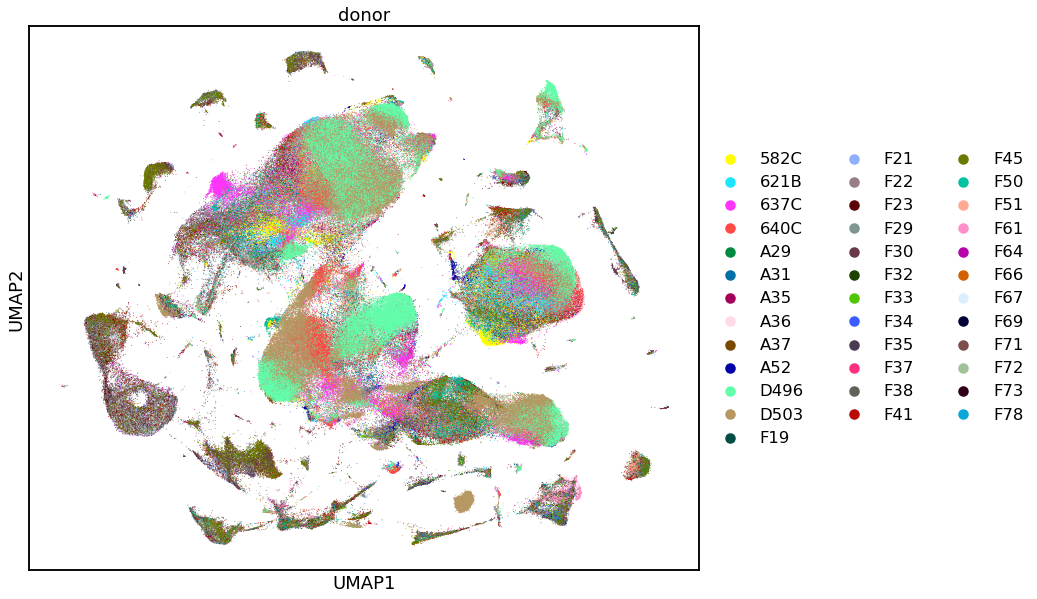

In [189]:
sc.pl.umap(merged_adata, color=['donor'], size=3, 
#            groups=keep_cts.tolist(),
          )

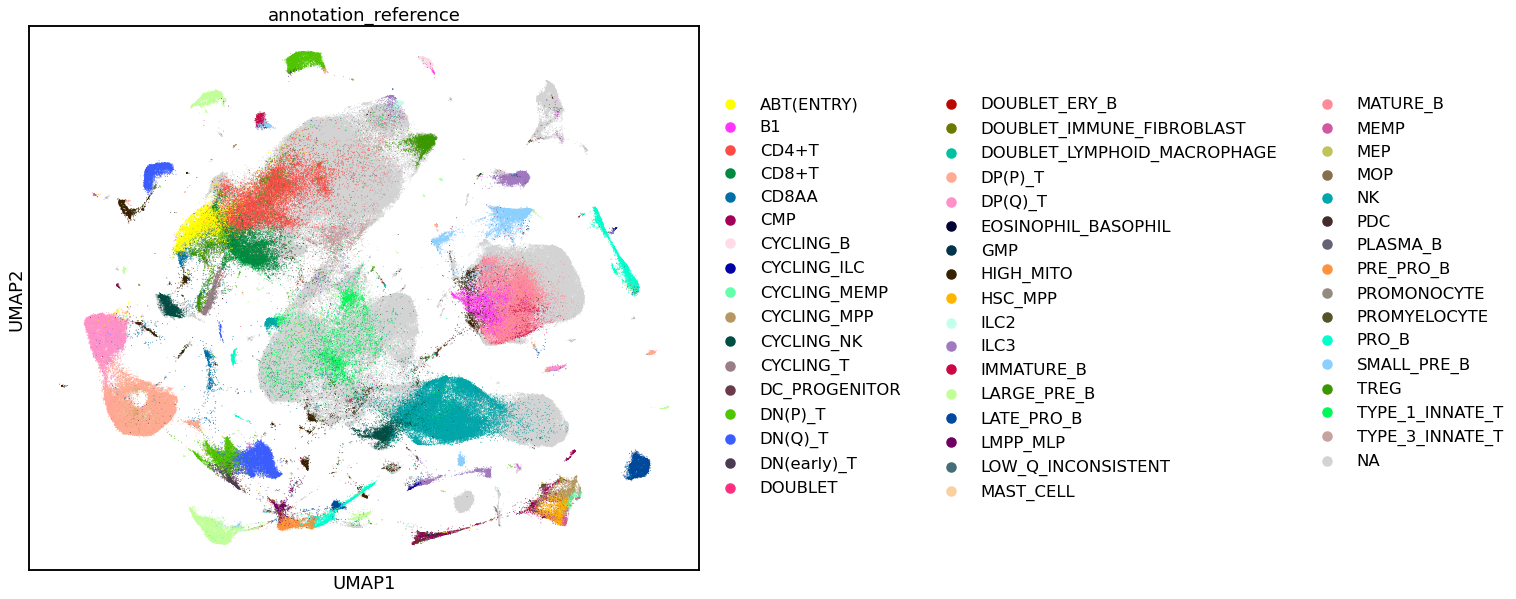

In [195]:
sc.pl.umap(merged_adata, color=['annotation_reference'], size=3, 
           groups=keep_cts.tolist(),
#            groups=["DN(P)_T", "LARGE_PRE_B"]
          )

In [204]:
qc_obs,qc_vars = sc.pp.calculate_qc_metrics(merged_adata_denovo, log1p=False)

In [206]:
qc_obs

n_genes_by_counts  total_counts  \
FCAImmP7579224-CTAATGGCACTGTGTA-fetal               5200       49847.0   
FCAImmP7579224-ATTATCCAGAGAACAG-fetal               4808       39019.0   
FCAImmP7579224-GACGGCTAGCCACCTG-fetal               5030       37050.0   
FCAImmP7579224-GCGGGTTGTCCGAGTC-fetal               4471       32467.0   
FCAImmP7579224-AGTTGGTAGTGTTAGA-fetal               4383       30336.0   
...                                                  ...           ...   
CZINY-0112_TTTGGTTAGGCCACTC-adult                   1708        4877.0   
CZINY-0112_TTTGGTTCACAAAGTA-adult                   2013        7147.0   
CZINY-0112_TTTGGTTTCCATCACC-adult                   1639        4471.0   
CZINY-0112_TTTGTTGCAGCGGTTC-adult                   1546        4645.0   
CZINY-0112_TTTGTTGGTGCGACAA-adult                   1387        3287.0   

                                       pct_counts_in_top_50_genes  \
FCAImmP7579224-CTAATGGCACTGTGTA-fetal                   38.082533   
FCAImmP7579224-ATTATCCAGAGAACAG-fetal                   42.510059   
FCAImmP7579224-GACGGCTAGCCACCTG-fetal                   31.840756   
FCAImmP7579224-GCGGGTTGTCCGAGTC-fetal                   34.256322   
FCAImmP7579224-AGTTGGTAGTGTTAGA-fetal                   35.452927   
...                                                           ...   
CZINY-0112_TTTGGTTAGGCCACTC-adult                       37.728112   
CZINY-0112_TTTGGTTCACAAAGTA-adult                       41.318036   
CZINY-0112_TTTGGTTTCCATCACC-adult                       35.786178   
CZINY-0112_TTTGTTGCAGCGGTTC-adult                       38.837460   
CZINY-0112_TTTGTTGGTGCGACAA-adult                       35.077578   

                                       pct_counts_in_top_100_genes  \
FCAImmP7579224-CTAATGGCACTGTGTA-fetal                    54.432564   
FCAImmP7579224-ATTATCCAGAGAACAG-fetal                    55.162869   
FCAImmP7579224-GACGGCTAGCCACCTG-fetal                    46.585695   
FCAImmP7579224-GCGGGTTGTCCGAGTC-fetal                    48.449195   
FCAImmP7579224-AGTTGGTAGTGTTAGA-fetal                    50.379088   
...                                                            ...   
CZINY-0112_TTTGGTTAGGCCACTC-adult                        48.410908   
CZINY-0112_TTTGGTTCACAAAGTA-adult                        56.219393   
CZINY-0112_TTTGGTTTCCATCACC-adult                        47.282487   
CZINY-0112_TTTGTTGCAGCGGTTC-adult                        53.369214   
CZINY-0112_TTTGTTGGTGCGACAA-adult                        46.851232   

                                       pct_counts_in_top_200_genes  \
FCAImmP7579224-CTAATGGCACTGTGTA-fetal                    65.689008   
FCAImmP7579224-ATTATCCAGAGAACAG-fetal                    64.696686   
FCAImmP7579224-GACGGCTAGCCACCTG-fetal                    57.578947   
FCAImmP7579224-GCGGGTTGTCCGAGTC-fetal                    59.953183   
FCAImmP7579224-AGTTGGTAGTGTTAGA-fetal                    61.850607   
...                                                            ...   
CZINY-0112_TTTGGTTAGGCCACTC-adult                        59.073201   
CZINY-0112_TTTGGTTCACAAAGTA-adult                        66.223590   
CZINY-0112_TTTGGTTTCCATCACC-adult                        58.152539   
CZINY-0112_TTTGTTGCAGCGGTTC-adult                        63.961249   
CZINY-0112_TTTGTTGGTGCGACAA-adult                        57.894737   

                                       pct_counts_in_top_500_genes  
FCAImmP7579224-CTAATGGCACTGTGTA-fetal                    76.066764  
FCAImmP7579224-ATTATCCAGAGAACAG-fetal                    75.263333  
FCAImmP7579224-GACGGCTAGCCACCTG-fetal                    69.306343  
FCAImmP7579224-GCGGGTTGTCCGAGTC-fetal                    72.193304  
FCAImmP7579224-AGTTGGTAGTGTTAGA-fetal                    73.196862  
...                                                            ...  
CZINY-0112_TTTGGTTAGGCCACTC-adult                        73.487800  
CZINY-0112_TTTGGTTCACAAAGTA-adult                        76.885406  
CZINY-0112_TTTGGTT

In [220]:
merged_adata_denovo.obs['n_genes_by_counts'] = qc_obs['n_genes_by_counts']
merged_adata_denovo.obs['total_counts'] = qc_obs['total_counts']
merged_adata_denovo.obs['pct_counts_in_top_100_genes'] = qc_obs['pct_counts_in_top_100_genes']

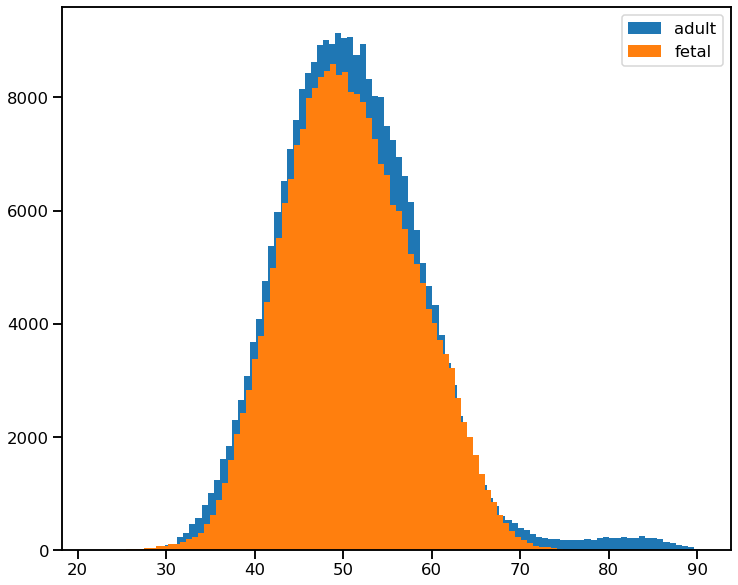

In [221]:
plt.hist(merged_adata_denovo[merged_adata_denovo.obs['dataset']== 'adult'].obs['pct_counts_in_top_100_genes'], bins=100, label='adult');
plt.hist(merged_adata_denovo[merged_adata_denovo.obs['dataset']== 'fetal'].obs['pct_counts_in_top_100_genes'], bins=100, label='fetal');
plt.legend()

## Compare with adult-only integration

In [43]:
query_h5ad_file = ref_data_dir+'panimmune_full_LYMPHOID_query.h5ad'
query_adata_full = sc.read_h5ad(query_h5ad_file) ## To add genes that are not used in scVI

In [44]:
X_scVI_adult = np.load('/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/panimmune_full.LYMPHOID.scVI_out.npy')

In [45]:
query_adata_full.obsm['X_scVI'] = X_scVI_adult.copy()

In [46]:
k_neighbors = 30
sc.pp.neighbors(query_adata_full, n_neighbors=k_neighbors, use_rep="X_scVI")
print("Running UMAP...\n")
sc.tl.umap(query_adata_full, min_dist = 0.01, spread = 2)

Running UMAP...



In [49]:
query_adata_full

AnnData object with n_obs × n_vars = 264929 × 21934
    obs: 'organ_code', 'donor', 'method', 'Category'
    var: 'gene_names', 'highly_variable', 'gene_ids', 'feature_types'
    uns: 'neighbors', 'umap', 'method_colors', 'donor_colors', 'Category_colors'
    obsm: 'X_umap', 'X_scVI'
    obsp: 'distances', 'connectivities'

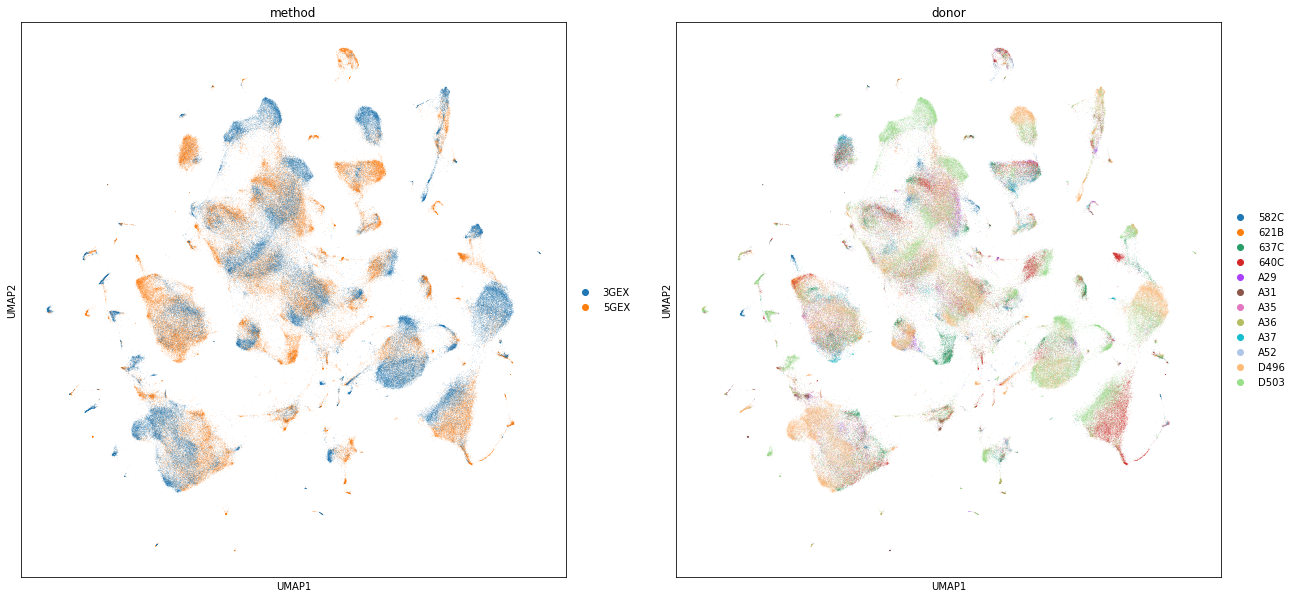

In [47]:
sc.pl.umap(query_adata_full, color=['donor'])

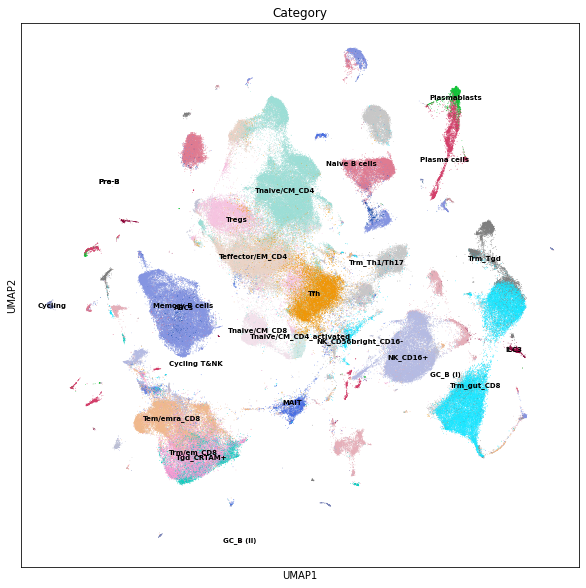

In [48]:
sc.pl.umap(query_adata_full, color=['Category'], size=2, legend_loc='on data', legend_fontsize=7)

## CellTypist prediciton

In [408]:
# pip install celltypist

In [436]:
ref_data_dir

'/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'

In [435]:
import celltypist

celltypist.models.download_models(force_update = True)

model = celltypist.models.Model.load(model = 'Pan_Fetal_Human.pkl')

query_h5ad_file = ref_data_dir+'panimmune_full_LYMPHOID_query.h5ad'
query_adata_full = sc.read_h5ad(query_h5ad_file)
sc.pp.normalize_per_cell(query_adata_full, counts_per_cell_after=1e4)
sc.pp.log1p(query_adata_full)

## match features in model
query_adata_full.var_names = query_adata_full.var['GeneName'].astype('str').values

predictions = celltypist.annotate(query_adata_full, model = model)

query_adata_full = predictions.to_adata()
n_cells = query_adata_full.obs['predicted_labels'].value_counts()
n_cells[0:30]

Trying to set attribute `.uns` of view, copying.


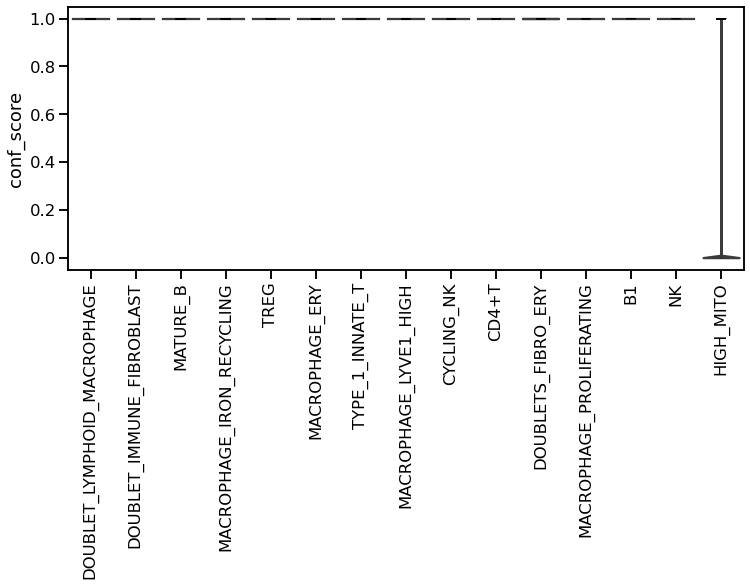

In [424]:
def _plot_sorted_violin(adata, groupby, y_value):
    n_cells_anno = adata.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = adata.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    adata.var_names_make_unique()
    sc.pl.violin(adata[adata.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)

plt.rcParams['figure.figsize'] = [10,5]
_plot_sorted_violin(query_adata_full, y_value='conf_score', groupby='predicted_labels')

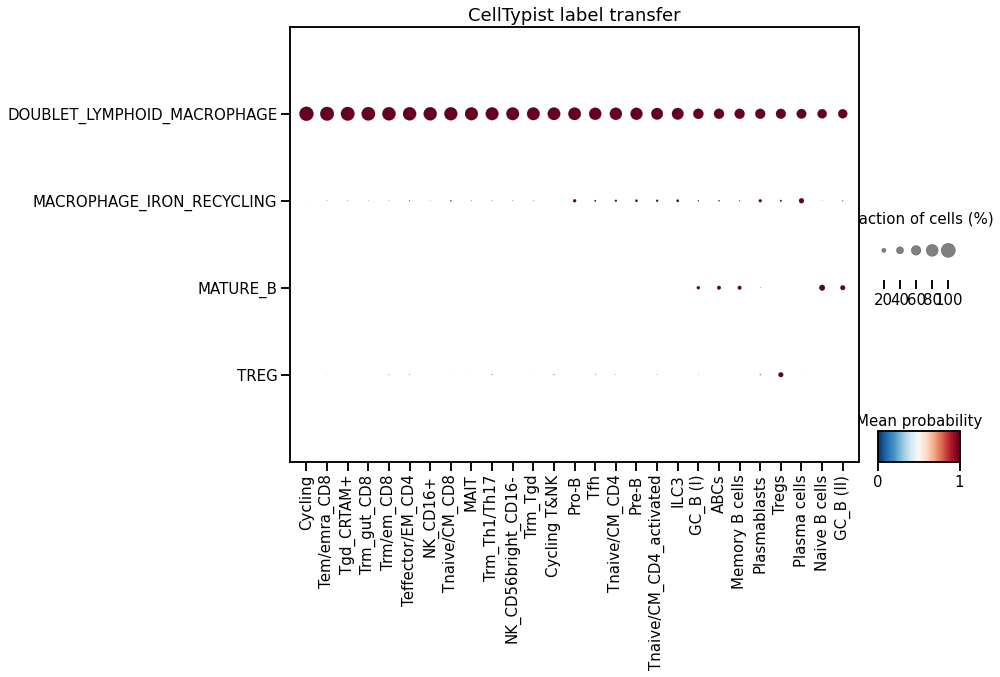

In [425]:
celltypist.plot.dotplot(predictions, use_as_reference='Category', use_as_prediction = 'predicted_labels',
                       filter_prediction=0.2, figsize=(12,8))

In [437]:
query_h5ad_file = ref_data_dir+'panimmune_full_MYELOID_query.h5ad'
query_adata_full = sc.read_h5ad(query_h5ad_file)
sc.pp.normalize_per_cell(query_adata_full, counts_per_cell_after=1e4)
sc.pp.log1p(query_adata_full)

In [438]:
## match features in model
query_adata_full.var_names = query_adata_full.var['GeneName'].astype('str').values

In [439]:
predictions = celltypist.annotate(query_adata_full, model = 'Pan_Fetal_Human.pkl')

🔬 Input data has 54047 cells and 31915 genes
🔗 Matching reference genes in the model
🧬 7121 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [440]:
query_adata_full = predictions.to_adata()
n_cells = query_adata_full.obs['predicted_labels'].value_counts()
n_cells[0:30]

MACROPHAGE_LYVE1_HIGH          19526
MONOCYTE_III_IL1B              13557
MONOCYTE_II_CCR2                4778
MONOCYTE_I_CXCR4                3628
MAST_CELL                       1629
MACROPHAGE_ERY                  1304
EOSINOPHIL_BASOPHIL             1082
DC2                             1058
MACROPHAGE_MHCII_HIGH            852
LOW_QUALITY_MACROPHAGE           763
MACROPHAGE_IRON_RECYCLING        749
PDC                              691
DC1                              371
PROMONOCYTE                      369
LATE_MK                          273
CMP                              272
PROMYELOCYTE                     253
MIGRATORY_DC                     212
HIGH_MITO                        197
GMP                              189
MEMP                             162
EARLY_ERY                        142
MEP                              119
MID_ERY                          112
LMPP_MLP                         107
MOP                              105
HSC_MPP                           86
M

Trying to set attribute `.uns` of view, copying.


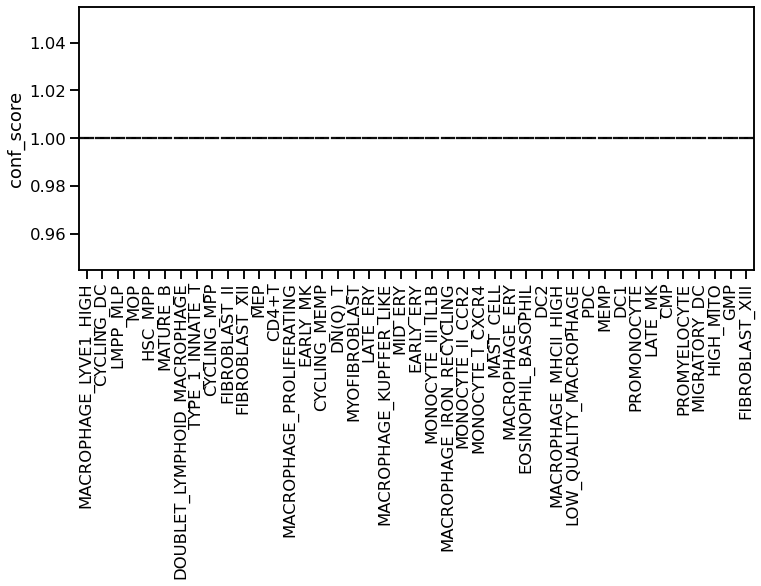

In [441]:
plt.rcParams['figure.figsize'] = [10,5]
_plot_sorted_violin(query_adata_full, y_value='conf_score', groupby='predicted_labels')

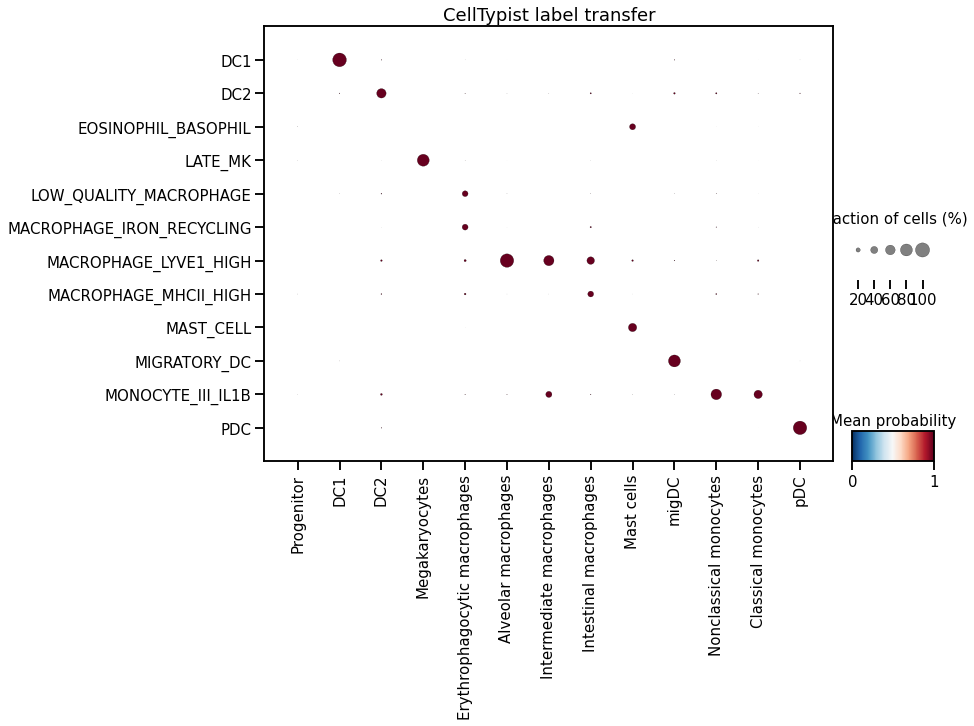

In [442]:
celltypist.plot.dotplot(predictions, use_as_reference='Category', use_as_prediction = 'predicted_labels',
                       filter_prediction=0.2, figsize=(12,8))


---

### Plot marker expression in mature B cells

In [35]:
merged_adata.var_names = merged_adata.var['GeneName'].astype('str').values.copy()

In [37]:
merged_adata.var_names_make_unique()

In [60]:
sc.pp.normalize_total(merged_adata,target_sum=10e04)

In [61]:
sc.pp.log1p(merged_adata)

In [62]:
query_ixs = merged_adata.obs['annotation_query'].isin(['GC_B (I)', 'GC_B (II)', "Naive B cells", "Memory B cells"])
ref_ixs = merged_adata.obs['annotation_reference']=="MATURE_B"

pl_adata = merged_adata[ ref_ixs | query_ixs ].copy()
pl_adata.obs['pl_annotation'] = np.nan
pl_adata.obs.loc[ref_ixs,'pl_annotation'] = pl_adata.obs.loc[ref_ixs, 'dataset'].astype('str') + "_" + pl_adata.obs.loc[ref_ixs, 'annotation_reference'].astype('str')
pl_adata.obs.loc[query_ixs,'pl_annotation'] = pl_adata.obs.loc[query_ixs, 'dataset'].astype('str') + "_" + pl_adata.obs.loc[query_ixs, 'annotation_query'].astype('str')

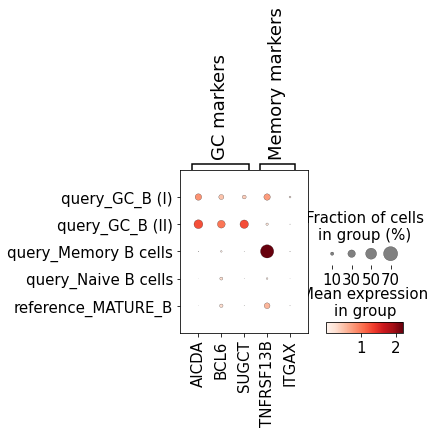

In [72]:
b_cell_markers = { ## Plucked from Conde et al.
    'GC markers':['AICDA','BCL6','SUGCT'],
    'Memory markers': ['TNFRSF13B','ITGAX']
}
plt.rcParams.update({'font.size': 18})
sc.pl.dotplot(pl_adata,
              b_cell_markers,
              groupby='pl_annotation', figsize=[4,3], save='matureB_expression.pdf')


## Mapping validation metrics

In [12]:
query_mapped_adata = merged_adata[merged_adata.obs['dataset'] == 'query'].copy()

sc.pp.neighbors(query_mapped_adata, use_rep='X_scvi', n_neighbors=30)

In [16]:
sc.tl.leiden(query_mapped_adata, resolution=0.5)

In [17]:
query_mapped_adata.obs['leiden'] = query_mapped_adata.obs['leiden'].astype("str")
query_mapped_adata.obs['annotation_query'] = query_mapped_adata.obs['annotation_query'].astype("str")

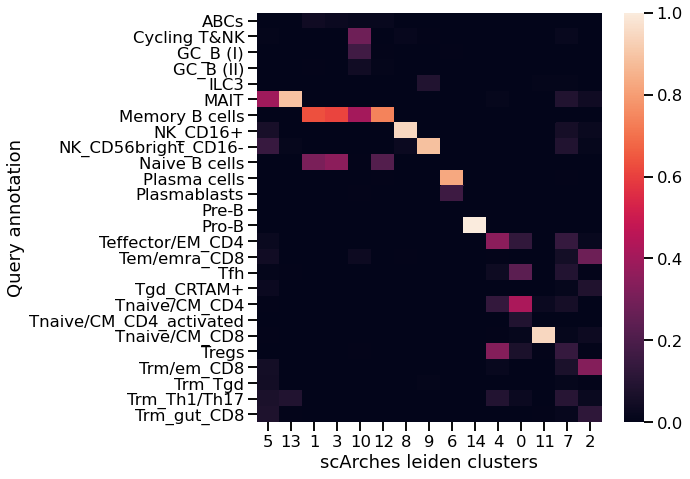

In [18]:
sns.set_context("talk")
keep_cts = query_mapped_adata.obs['annotation_query'].value_counts().index[query_mapped_adata.obs['annotation_query'].value_counts() > 10]
keep_cts = keep_cts[keep_cts!='nan']
conf_mat = sc.metrics.confusion_matrix('leiden','annotation_query', 
                                       query_mapped_adata.obs[query_mapped_adata.obs['annotation_query'].isin(keep_cts)]).T

col_order = conf_mat.idxmax(0).sort_values().index
conf_mat = conf_mat[col_order] ## Sort to have some sort of diagonal

plt.rcParams['figure.figsize'] = [10, 7]
sns.heatmap(conf_mat, xticklabels=True, yticklabels=True);
plt.xlabel("scArches leiden clusters");
plt.ylabel("Query annotation");
plt.tight_layout();
plt.savefig(figdir + 'validation_conf_mat.pdf')

In [22]:
query_mapped_adata.obs.columns

Index(['n_counts', 'n_genes', 'file', 'mito', 'doublet_scores',
       'predicted_doublets', 'name', 'sample', 'Source ID', 'sex',
       'patient no', 'organ code', 'sample ID', 'fraction_mito', 'log_counts',
       'batch', 'empty', 'bonf_pval', 'is_doublet', 'scrublet_score',
       'louvain', 'louvain_R', 'scrublet_cluster_score', 'zscore', 'bh_pval',
       'leiden', 'predicted_labels', 'over_clustering', 'majority_voting',
       'leiden5', 'leiden10', 'leiden15', 'leiden20', 'cx1_anno',
       'leiden_majority_anno', 'leiden1.5', 'anno', 'anno_mye', 'anno_T_2',
       'anno_B_v2', 'dataset', 'annotation_reference', 'annotation_query',
       'predicted_anno_prob', 'knn_sim', 'mnn_sim', 'mnn_sim_ratio',
       'precited_anno_prob', 'min_distance2pred', 'predicted_anno',
       'predicted_anno_unfiltered'],
      dtype='object')

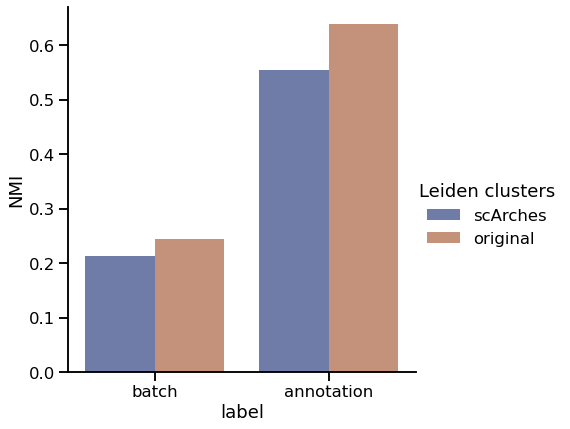

In [23]:
import sklearn
nmi_anno_old = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['annotation_query'], query_mapped_adata.obs["leiden5"])
nmi_anno_new = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['annotation_query'], query_mapped_adata.obs["leiden"])
nmi_batch_old = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['batch'], query_mapped_adata.obs["leiden10"])
nmi_batch_new = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['batch'], query_mapped_adata.obs["leiden"])

df = pd.DataFrame([nmi_batch_new, nmi_batch_old,nmi_anno_new, nmi_anno_old])
df.columns = ['NMI']
df['cat'] = ['batch_scArches', 'batch_original', 'annotation_scArches', "annotation_original"]
df['Leiden clusters'] = [x[1] for x in df['cat'].str.split("_")]
df['label'] = [x[0] for x in df['cat'].str.split("_")]

sns.catplot(
    data=df, kind="bar",
    x="label", y="NMI", hue='Leiden clusters',
    ci="sd", palette="dark", alpha=.6, height=6
)
plt.savefig(figdir + 'validation_barplot.pdf')

---

In [59]:
[x for x in os.listdir(data_dir) if 'LYMPHOID_NEW' in x]

['PAN.A01.v01.entire_data_raw_count.20210429.LYMPHOID_NEW.h5ad',
 'PAN.A01.v01.entire_data_normalised_log.20210429.LYMPHOID_NEW.var.csv',
 'PAN.A01.v01.entire_data_raw_count.20210429.MYELOID_LYMPHOID_NEW.h5ad',
 'PAN.A01.v01.entire_data_normalised_log.20210429.LYMPHOID_NEW.h5ad',
 'PAN.A01.v01.entire_data_normalised_log.20210429.MYELOID_LYMPHOID_NEW.h5ad',
 'panimmune_full_LYMPHOID_query.mapped2LYMPHOID_NEW.confusion_table.csv']

In [100]:
adata_fetal = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.20210429.LYMPHOID_NEW.h5ad', backed='r')

In [84]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)

In [85]:
adata_fetal.obs = anno_obs.loc[adata_fetal.obs_names].copy()

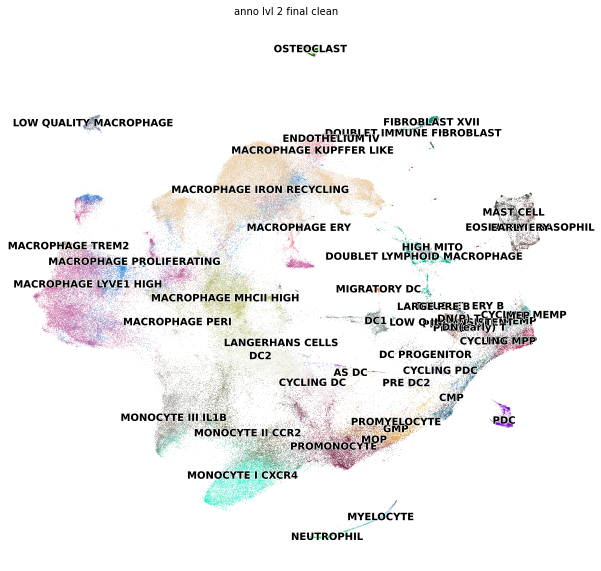

In [86]:
keep_annos = adata_fetal.obs['anno_lvl_2_final_clean'].value_counts().index[adata_fetal.obs['anno_lvl_2_final_clean'].value_counts() > 20]
scv.pl.umap(adata_fetal, color='anno_lvl_2_final_clean', legend_loc='on data', groups=keep_annos.tolist(), )

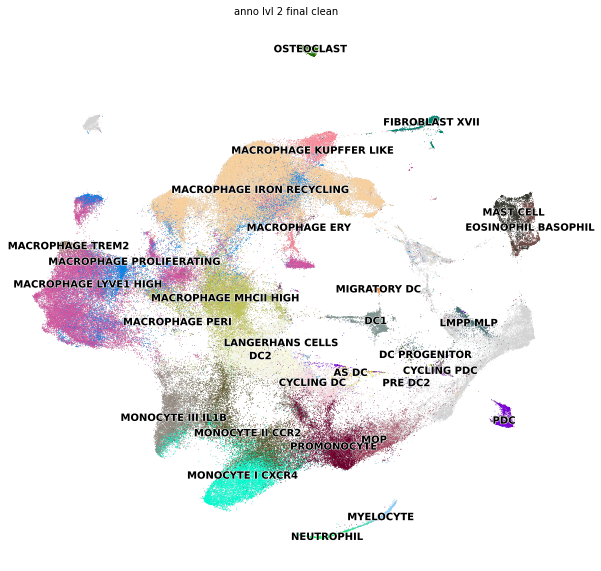

In [88]:
scv.pl.umap(adata_fetal, color='anno_lvl_2_final_clean', legend_loc='on data', groups=anno_groups_dict['MYELOID'], size=2)


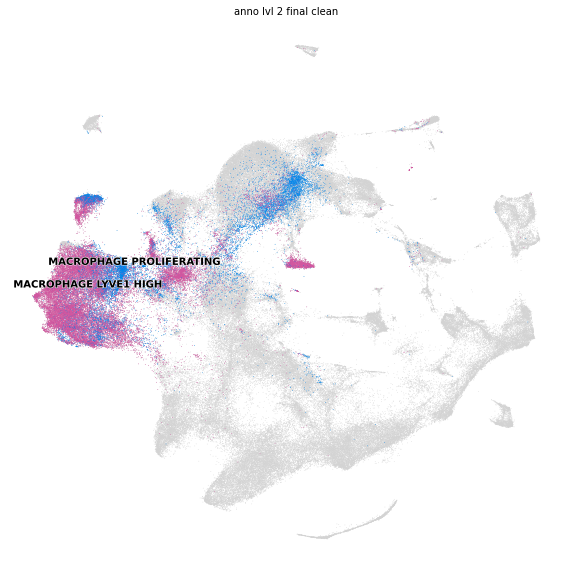

In [91]:
scv.pl.umap(adata_fetal, color='anno_lvl_2_final_clean', legend_loc='on data', groups=['MACROPHAGE_PROLIFERATING', 'MACROPHAGE_LYVE1_HIGH'], size=2)


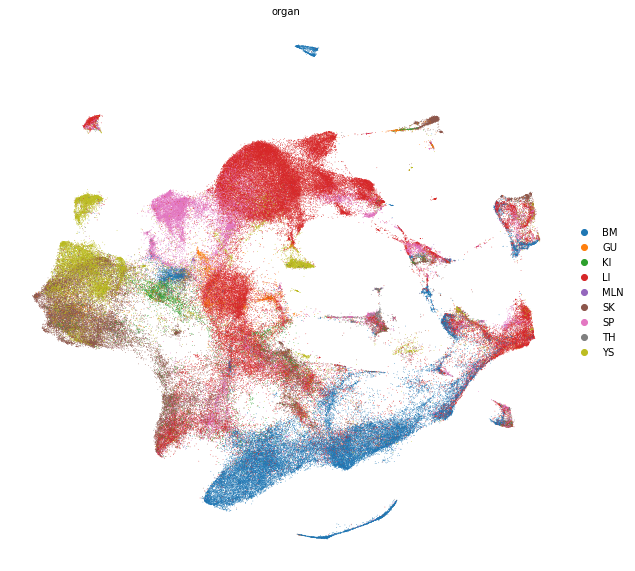

In [95]:
scv.pl.umap(adata_fetal, color=['organ'],  legend_loc='right margin',size=2)
